In [1]:
import os
import sys
import pickle
import string

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from matplotlib import ticker

from utils import *
from AnalyseDefects import AnalyseDefects

plt.style.use('sg_article')
plt.rcParams.update({"text.usetex": True,})


In [2]:

def extract_clp_results_single(clustering_dict, act_dir_list, save_path = None):
    """
    Analyse the defects for all the input folders
    """

    Nframes = clustering_dict['Nframes']
  
    # create arrays to store the clustering data
    cluster_arr = np.nan * np.zeros([Nframes, clustering_dict['Nwindows'], 3, clustering_dict['Nact'],])
    nn_arr = np.nan * np.zeros([Nframes, 2, clustering_dict['Nact']])

    for i, act_dir in enumerate(act_dir_list):
        print(i, act_dir)
        cl_res = np.load(os.path.join(act_dir, 'cl_arr.npy'))
        nn_res = np.load(os.path.join(act_dir, 'nn_arr.npy'))
        ff_idx = min(Nframes, cl_res.shape[0])
        cluster_arr[-ff_idx:, :cl_res.shape[1], :, i] = cl_res[-ff_idx:]
        nn_arr[-ff_idx:, :, i] = nn_res[-ff_idx:]

    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, f'clp_arr.npy'), cluster_arr)
        np.save(os.path.join(save_path, f'nn_arr.npy'), nn_arr)
    return cluster_arr

def extract_op_results(Nframes, act_dir_list, LX, calc_sem = False, save_path = None):
    """
    Analyse the defects for all the input folders
    """

    order_param_arr = np.nan * np.zeros([Nframes, 4, len(act_dir_list)])
    normalizer = np.sqrt(LX ** 2) if calc_sem else 1

    for i, act_dir in enumerate(act_dir_list):
        print(i, act_dir)

        op_res = np.load(os.path.join(act_dir, 'order_param_arr.npy'))
        ff_idx = min(Nframes, op_res.shape[0])

        order_param_arr[-ff_idx:, :, i] = op_res[-ff_idx:]
        order_param_arr[-ff_idx:, 1, i] /= normalizer
        order_param_arr[-ff_idx:, 3, i] /= normalizer

    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, f'order_param_arr.npy'), order_param_arr)
    return order_param_arr

def extract_dc_results(Nframes, act_dir_list, save_path = None):
    """
    Analyse the defects for all the input folders
    """

    for i, act_dir in enumerate(act_dir_list):
        print(i, act_dir)

        if i == 0:
            rvals = np.load(os.path.join(act_dir, 'rdf_rad_arr.npy'))
            rdf_arr = np.nan * np.zeros([Nframes, len(rvals), len(act_dir_list)])

        rdf = np.load(os.path.join(act_dir, 'rdf_arr.npy'))
        ff_idx = min(Nframes, rdf.shape[0])

        rdf_arr[-ff_idx:, :, i] = rdf[-ff_idx:]

    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, f'rvals.npy'), rvals)
        np.save(os.path.join(save_path, f'rdf_arr.npy'), rdf_arr)
    return rdf_arr, rvals

def get_defect_arr_from_frame(defect_dict, return_charge = False):
    """
    Convert dictionary of defects to array of defect positions
    Parameters:
    -----------
    defect_dict : dict
        Dictionary of defects positions and charges
    return_charge : bool
        If True, return defect charges as well

    Returns:
    --------
    defect_positions : np.ndarray
        Array of defect positions
    defect_charges : np.ndarray
    """

    Ndefects = len(defect_dict)
    if Ndefects == 0:
        return None
    
    defect_positions = np.empty([Ndefects, 3 if return_charge else 2])

    for i, defect in enumerate(defect_dict):
        if return_charge:
            defect_positions[i,:] = *defect['pos'], defect['charge']
        else:
            defect_positions[i,:] = *defect['pos'],
    return defect_positions

def arg_func(arr, r_max_list, cutoff):
    if np.any(arr == cutoff):
        return r_max_list[np.argwhere(arr == cutoff)[0][0]]
    else:
        return -1
    
def arg_func_idx(arr, cutoff):
    if np.any(arr == cutoff):
        return np.argwhere(arr == cutoff)[0][0]
    else:
        return -1

def arg_func2(arr, cutoff):
    if np.any(arr == cutoff):
        return arr[np.argwhere(arr == cutoff)[0][0]]
    else:
        return -1
    
def get_defect_density(defect_list, area, return_charges=False, save_path = None,):
        """
        Get defect density for each frame in archive
        parameters:
            defect_list: list of lists of dictionaries holding defect charge and position for each frame 
            area: Area of system
            return_charges: if True, return list of densities of positive and negative defects
        returns:
            dens_defects: array of defect densities (Nframes, 3) if return_charges is True else (Nframes, 2)
        """

        if return_charges:
            # Initialize list of defect densities
            dens_pos_defects = []
            dens_neg_defects = []
            for defects in defect_list:
                # Get no. of defects
                nposdef = len([d for d in defects if d['charge'] == 0.5])
                nnegdef = len([d for d in defects if d['charge'] == -0.5])

                dens_pos_defects.append(nposdef / area)
                dens_neg_defects.append(nnegdef / area)

            if save_path is not None:
                np.savetxt(save_path + '_pos', dens_pos_defects)
                np.savetxt(save_path + '_neg', dens_neg_defects)
            return dens_pos_defects, dens_neg_defects
        else:
            dens_defects = []
            for defects in defect_list:
                # Get no. of defects
                ndef = len(defects)
                dens_defects.append(ndef / area)
            if save_path is not None:
                np.savetxt(save_path, dens_defects)
            return dens_defects

def find_conv_time(def_arr, act_list, out_path, fig_path, ninfo, LX, mode='fwd', plot_density = False, \
                   stationarity_dict = dict(interval_len = 20, Njump = 20, Nconverged = -100, max_sigma_dist = 1)):

    Nframes, Nact = def_arr.shape
    conv_list = np.zeros(Nact)

    ncols=3
    nrows = np.ceil(Nact / ncols).astype(int)
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols, figsize=(12, 3*nrows))
    ax = ax.flatten()


    for i, act in enumerate(act_list):

            normalizer = LX ** 2 if plot_density else 1
            vals = def_arr[:, i] / normalizer

            av = np.mean(vals)
        

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                x = est_stationarity(vals, **stationarity_dict)[0]

            conv_list[i] = x
            ax[i].plot(np.arange(0, Nframes * ninfo, ninfo), vals, '.',
                        alpha = .5, markersize=9, label = rf'$dQ$ = {act}')
        
            if x > 0:
                ax[i].axvline(x * ninfo, color='black', linestyle='--', alpha=0.5)
            ax[i].set_ylim([0, 2 * av])
            ax[i].legend()  
            ax[i].grid(True)


    fig.supxlabel('Time')
    fig.supylabel('Number of defects')


    np.save(os.path.join(out_path, 'conv_list.npy'), conv_list)
    fig.savefig(os.path.join(fig_path, f'num_defects_{mode}{LX}.png'))

    # close figure
    plt.close(fig)
    return

def calc_lmax_lperc(clp_arr, rmax_list, act_list, conv_list, save_path, uncertainty_multiplier = 1, nmin_frames = 20):
    

    lmax_av = np.nan * np.zeros((len(act_list), 2))
    lperc_av = np.nan * np.zeros((len(act_list), 2))

    arg_func1d = lambda arr: arg_func(arr, rmax_list, cutoff = 1)
    lmax_arr = np.apply_along_axis(arg_func1d, axis=1, arr=clp_arr[:, :, -1, :,])
    lperc_arr = np.apply_along_axis(arg_func1d, axis=1, arr=clp_arr[:, :, 0, :,])

    for i, _ in enumerate(act_list):
        ff_idx = int(conv_list[i])

        mask = (lmax_arr[ff_idx:, i,] > 0)
        nsamples = mask.sum()
        if nsamples > nmin_frames:
            arr_res = lmax_arr[ff_idx:, i,][mask]
            lmax_av[i,0] = np.nanmean(arr_res)
            lmax_av[i,1] = np.nanstd(arr_res, ddof = 1,) / np.sqrt(nsamples / uncertainty_multiplier)


        mask_perc = (lperc_arr[ff_idx:, i,] > 0)
        nsamples_perc = mask_perc.sum()
        if nsamples_perc  > nmin_frames:
            arr_res_perc = lperc_arr[ff_idx:, i,][mask_perc]
            lperc_av[i,0] = np.nanmean(arr_res_perc)
            lperc_av[i,1] = np.nanstd(arr_res_perc, ddof = 1,) / np.sqrt(nsamples_perc / uncertainty_multiplier)

    np.save(os.path.join(save_path, 'lmax_arr.npy'), lmax_arr)
    np.save(os.path.join(save_path, 'lperc_arr.npy'), lperc_arr)
    np.save(os.path.join(save_path, 'lmax_av.npy'), lmax_av)
    np.save(os.path.join(save_path, 'lperc_av.npy'), lperc_av)
    return

def calc_nn_avg(nn_arr, def_arr, act_list, conv_list, LX, \
                uncertainty_multiplier = 1, weighted=False, \
                normalize = True, nmin_samples = 20, 
                save_path = None):
    
    nn_av = np.nan * np.zeros((len(act_list), 2))

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for j in range(len(act_list)):
            ff_idx = int(conv_list[j])
            normalizer = LX / np.sqrt(def_arr[ff_idx:,j]) if normalize else 1
            
            if (nn_arr[:,0,j] > 0).sum() >=  nmin_samples:
                if weighted:
                    nn_av[j] = calc_weighted_mean_vec(nn_arr[ff_idx:,0,j] / normalizer, 
                                                                nn_arr[ff_idx:,1,j] / normalizer, replace_null_uncertainties=True)[:2]
                    nn_av[j,1] *= np.sqrt(uncertainty_multiplier)
                else:
                    nn_av[j,0] = np.nanmean(nn_arr[ff_idx:,0,j] / normalizer)
                    nn_av[j,1] = np.nanstd(nn_arr[ff_idx:,0,j] / normalizer, ddof = 1,) \
                        / np.sqrt(nn_arr[ff_idx:,0,j].size / uncertainty_multiplier)           
    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, 'nn_av.npy'), nn_av)
    return nn_av

def calc_dc_avg(rdf_arr, act_list, conv_list, \
                uncertainty_multiplier = 1, njump=5,
                save_path = None):
    

    
    rdf_arr_av = np.nan * np.zeros((len(act_list), 2, rdf_arr.shape[1]))
  
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for j in range(len(act_list)):
            ff_idx = int(conv_list[j] / njump)
            rdf_arr_res = rdf_arr[ff_idx:,:,j]
            #nan_mask = np.isnan(rdf_arr_res)
            #rdf_arr_res = rdf_arr_res[~nan_mask]

            rdf_arr_av[j,0,:] = np.nanmean(rdf_arr_res, axis=0)
            rdf_arr_av[j,1,:] = np.nanstd(rdf_arr_res, axis=0, ddof = 1,) \
                / np.sqrt(rdf_arr_res.size / uncertainty_multiplier)        
    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, 'rdf_arr_av.npy'), rdf_arr_av)
    return rdf_arr_av

def calc_order_param_avg(order_param_arr, act_list, conv_list, \
                uncertainty_multiplier = 1, weighted=False, \
                save_path = None):
    
    order_param_av = np.nan * np.zeros((len(act_list), 4))

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for j in range(len(act_list)):
            ff_idx = int(conv_list[j])
   
            if weighted:
                order_param_av[j, :2] = calc_weighted_mean_vec(order_param_arr[ff_idx:,0,j], 
                                                            order_param_arr[ff_idx:,1,j] * np.sqrt(uncertainty_multiplier))[:2]
                order_param_av[j, 2:] = calc_weighted_mean_vec(order_param_arr[ff_idx:,2,j], 
                                                            order_param_arr[ff_idx:,3,j] * np.sqrt(uncertainty_multiplier))[:2]
                order_param_av[j,1] *= np.sqrt(uncertainty_multiplier)
                order_param_av[j,3] *= np.sqrt(uncertainty_multiplier)
            else:
                order_param_av[j,0] = np.nanmean(order_param_arr[ff_idx:,0,j])
                order_param_av[j,1] = np.nanstd(order_param_arr[ff_idx:,0,j], ddof = 1,) \
                    / np.sqrt(order_param_arr[ff_idx:,0,j].size / uncertainty_multiplier)           
                order_param_av[j,2] = np.nanmean(order_param_arr[ff_idx:,2,j])
                order_param_av[j,3] = np.nanstd(order_param_arr[ff_idx:,2,j], ddof = 1,) \
                    / np.sqrt(order_param_arr[ff_idx:,2,j].size / uncertainty_multiplier)           
    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, 'order_param_av.npy'), order_param_av)
    return order_param_av
        
def plot_order_param(order_param_arr, act_list, Nframes, ninfo, \
                    act_idx_exclude_list = [], lambda_val=None, save_path=None, \
                    ylim = None, mode = 'wet', direction = 'fwd'):
    
    fig, ax = plt.subplots()

    direction = 'forward' if direction == 'fwd' else 'backward'

    for j in range(len(act_list)):
        if j in act_idx_exclude_list: continue

        xvals = np.arange(0, Nframes * ninfo, ninfo)
        ax.plot(xvals, order_param_arr[:,0,j], '.-', label  = f'{act_list[j]}', alpha = .5)
    ax.set_xlabel('Time step')
    ax.set_ylabel('Order parameter (S)')

    ax.legend(ncols=7, loc='upper right',fontsize=12)   
    ax.set_title(rf' $\lambda = ${lambda_val} ({direction})' if mode == 'wet' else rf'Dry ({direction})')
    if ylim is not None:
        ax.set_ylim(ylim)

    fig.tight_layout()  

    if save_path is not None:
        fig.savefig(save_path)
    return fig, ax

def plot_order_param_double(order_param_arr, act_list, idx_lower, Nframes, ninfo, \
                    act_idx_exclude_list = [], lambda_val=None, save_path=None, \
                    ylim_list = None, mode = 'wet', direction = 'fwd'):
    
    fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
    for j in range(len(act_list)):
        if j in act_idx_exclude_list: continue
        ff_idx = 0
        ax[0 if j<idx_lower else 1].plot(order_param_arr[:,0,j], label  = f'{act_list[j]}')
    fig.supxlabel('Time step')
    fig.supylabel('Order parameter (S)')
    fig.suptitle(rf' $\lambda = ${lambda_val} ({direction})' if mode == 'wet' else rf'Dry ({direction})')
    fig.tight_layout()

    for i, axx in enumerate(ax):
        axx.set_ylim([-.05, .25]) if ylim_list is None else axx.set_ylim(ylim_list[i])
        axx.legend(ncol=4, loc='upper right', fontsize=12)

    if save_path is not None:
        fig.savefig(save_path)
    return fig, ax


In [3]:
LX = 256
mode = 'dry' 

calc_order_param_sem = False
extract = False
extract_op, extract_dc = False, False
extract_def, find_conv = False, False
analyze= True

if mode == 'wet':
    folder_name = 'diff_lambda_periodic'
    lambda_list = [0,1]#.1,.5,.8,1,]
    subdir_name = 'wet'
elif mode == 'dry':
    folder_name = 'dry_periodic_long'
    lambda_list = [1,]
    subdir_name = 'dry'
elif mode == 'ac':
    folder_name = 'ac_periodic'
    lambda_list = [0,1]
    subdir_name = 'wet'

out_path_all = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\{folder_name}\{mode}\\na{LX}'
defect_position_dir = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive'
#figpath_article = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\figs'
figpath_article='C:\\Users\\Simon Andersen\\Documents\\Uni\\PhD\\jayeeta_passive\\Figs'

for lambda_val in lambda_list:

    base_path_fwd = f'X:\\{folder_name}\\{subdir_name}\\na{LX}\\{lambda_val}\\fwd'
    base_path_bck = f'X:\\{folder_name}\\{subdir_name}\\na{LX}\\{lambda_val}\\bck'
    if extract_def:
        base_path_defects_fwd = f'X:\\{folder_name}\\{subdir_name}\\na{LX}\\{lambda_val}\\defect_positions\\fwd'
        base_path_defects_bck = f'X:\\{folder_name}\\{subdir_name}\\na{LX}\\{lambda_val}\\defect_positions\\bck'

   # base_path_defects_fwd = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\{folder_name}\\{mode}\\na{LX}\\{lambda_val}\\defect_positions\\fwd'
   # base_path_defects_bck = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\{folder_name}\\{mode}\\na{LX}\\{lambda_val}\\defect_positions\\bck'

    out_path_main = os.path.join(out_path_all, f'{lambda_val}') #if mode == 'wet' else out_path_all
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')
    fig_path = os.path.join(out_path_main, 'figs')

    if extract or extract_def or extract_op or extract_dc:
        if not os.path.isdir(fig_path):
            os.makedirs(fig_path)
        if not os.path.isdir(out_path_main):
            os.makedirs(out_path_main)
        if not os.path.isdir(out_path_fwd):
            os.makedirs(out_path_fwd)
        if not os.path.isdir(out_path_bck):
            os.makedirs(out_path_bck)

        print(f'Analyzing {mode} with lambda = {lambda_val}')
        t1 = time.perf_counter()    

        act_dirs_fwd = [os.path.join(base_path_fwd, x) for x in os.listdir(base_path_fwd)]
        act_dirs_bck = [os.path.join(base_path_bck, x) for x in os.listdir(base_path_bck)] 

        if extract_def:
            act_dirs_def_fwd = [os.path.join(base_path_defects_fwd, x) for x in os.listdir(base_path_defects_fwd)]
            act_dirs_def_bck = [os.path.join(base_path_defects_bck, x) for x in os.listdir(base_path_defects_bck)]

        act_fwd = [float(x.split('-')[-2]) for x in os.listdir(base_path_fwd)]
        act_bck = [float(x.split('-')[-2]) for x in os.listdir(base_path_bck)]

        # save activity list
        np.save(os.path.join(out_path_fwd, 'act_fwd.npy'), act_fwd)
        np.save(os.path.join(out_path_bck, 'act_bck.npy'), act_bck)
    else:
        act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
        act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))

    act_exclude_fwd = []
    act_exclude_bck = []

    Nact_fwd = len(act_fwd)
    Nact_bck = len(act_bck)
    Nact_list = [Nact_fwd, Nact_bck]

    rmax_list = np.arange(1, int(LX / np.sqrt(2))) 
    Nframes = 1000 #if mode=='wet' #else 50
    Nwindows = len(rmax_list)
    ninfo = 1000

    cluster_dict_fwd = dict(LX = LX, Nframes = Nframes, \
                        Nact = len(act_fwd), \
                        Nwindows = len(rmax_list), \
                        path = out_path_fwd, suffix = '_fwd')
    cluster_dict_bck = dict(LX = LX, Nframes = Nframes, \
                        Nact = len(act_bck), \
                        Nwindows = len(rmax_list), \
                        path = out_path_bck, suffix = '_bck')
    
    if extract_def:
            def_arr_fwd = np.zeros([Nframes, Nact_fwd])
            def_arr_bck = np.zeros([Nframes, Nact_bck])

            for i, (act_dir_list, arr) in enumerate(zip([act_dirs_def_fwd, act_dirs_def_bck], [def_arr_fwd, def_arr_bck])):
                print("Extracting defects for", 'fwd' if i == 0 else 'bck')
                for j, act_dir in enumerate(act_dir_list):
                    print(j)
                    path = os.path.join(act_dir, 'defect_positions.pkl')
                    with open(path, 'rb') as f:
                        defect_dict = pickle.load(f)
                    def_list_pos = get_defect_density(defect_dict, area = 1)
                    ff_idx = min(Nframes, len(def_list_pos))
                    arr[-ff_idx:, j] = def_list_pos[-ff_idx:]

            # save 
            np.save(os.path.join(out_path_fwd, 'def_arr.npy'), def_arr_fwd)
            np.save(os.path.join(out_path_bck, 'def_arr.npy'), def_arr_bck)
    if extract:
        clp_arr_fwd = extract_clp_results_single(cluster_dict_fwd, act_dirs_fwd, save_path=out_path_fwd)
        clp_arr_bck = extract_clp_results_single(cluster_dict_bck, act_dirs_bck, save_path=out_path_bck)
    else:
        clp_arr_fwd = np.load(os.path.join(out_path_fwd, 'clp_arr.npy'))
        clp_arr_bck = np.load(os.path.join(out_path_bck, 'clp_arr.npy'))
        def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))
        def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
        nn_arr_fwd = np.load(os.path.join(out_path_fwd, 'nn_arr.npy'))
        nn_arr_bck = np.load(os.path.join(out_path_bck, 'nn_arr.npy'))
    if extract_op:
        order_param_arr_fwd = extract_op_results(Nframes, act_dirs_fwd, LX, calc_sem=calc_order_param_sem, save_path=out_path_fwd)
        order_param_arr_bck = extract_op_results(Nframes, act_dirs_bck, LX, calc_sem=calc_order_param_sem, save_path=out_path_bck)
    else:
        try:
            order_param_arr_fwd = np.load(os.path.join(out_path_fwd, 'order_param_arr.npy'))
            order_param_arr_bck = np.load(os.path.join(out_path_bck, 'order_param_arr.npy'))
        except:
            pass
    if extract_dc:
        rdf_arr_fwd, rvals_fwd = extract_dc_results(Nframes, act_dirs_fwd, save_path=out_path_fwd)
        rdf_arr_bck, rvals_bck = extract_dc_results(Nframes, act_dirs_bck, save_path=out_path_bck)
    else:
        try:
            rdf_arr_fwd = np.load(os.path.join(out_path_fwd, 'rdf_arr.npy'))
            rdf_arr_bck = np.load(os.path.join(out_path_bck, 'rdf_arr.npy'))
            rvals_fwd = np.load(os.path.join(out_path_fwd, 'rvals.npy'))
            rvals_bck = np.load(os.path.join(out_path_bck, 'rvals.npy'))
        except:
            pass
    if not find_conv:
        try:
            conv_list_fwd = np.load(os.path.join(out_path_fwd, 'conv_list.npy'))
            conv_list_bck = np.load(os.path.join(out_path_bck, 'conv_list.npy'))
        except:
            conv_list_bck = np.zeros(Nact_bck)
            conv_list_fwd = np.zeros(Nact_fwd)
    else:
        block_size = 20 #if mode=='wet' else 5
        Nconverged = 5*block_size
        find_conv_time(def_arr_fwd, act_fwd, out_path_fwd, fig_path, ninfo, LX, mode='fwd', plot_density = False, \
                stationarity_dict = dict(interval_len = block_size, Njump = block_size, Nconverged = Nconverged, max_sigma_dist = 1))
        find_conv_time(def_arr_bck, act_bck, out_path_bck, fig_path, ninfo, LX, mode='bck', plot_density = False, \
                stationarity_dict = dict(interval_len = block_size, Njump = block_size, Nconverged = Nconverged, max_sigma_dist = 1))
    if analyze:
        print('Analyzing', lambda_val) 
        nmin_frames = 20 #if #mode == 'wet' else 5
        uncertainty_multiplier = 10
        njump_between_frames = 5
        calc_lmax_lperc(clp_arr_fwd, rmax_list, act_fwd, conv_list_fwd, out_path_fwd, \
                        uncertainty_multiplier = uncertainty_multiplier/5 if Nframes<100 else uncertainty_multiplier, \
                            nmin_frames = nmin_frames)
        calc_lmax_lperc(clp_arr_bck, rmax_list, act_bck, conv_list_bck, out_path_bck, \
                        uncertainty_multiplier = uncertainty_multiplier/5 if Nframes<100 else uncertainty_multiplier, \
                            nmin_frames = nmin_frames)
        calc_nn_avg(nn_arr_fwd, def_arr_fwd, act_fwd, conv_list_fwd, LX, \
                uncertainty_multiplier = uncertainty_multiplier, weighted=True, normalize = True, nmin_samples = nmin_frames, 
                save_path = out_path_fwd)
        calc_nn_avg(nn_arr_bck, def_arr_bck, act_bck, conv_list_bck, LX, \
                uncertainty_multiplier = uncertainty_multiplier, weighted=True, normalize = True, nmin_samples = nmin_frames, 
                save_path = out_path_bck)
        order_param_fwd_av = calc_order_param_avg(order_param_arr_fwd, act_fwd, conv_list_fwd, \
                uncertainty_multiplier = uncertainty_multiplier, weighted=True, save_path = out_path_fwd)
        order_param_bck_av = calc_order_param_avg(order_param_arr_bck, act_bck, conv_list_bck, \
                uncertainty_multiplier = uncertainty_multiplier, weighted=True, save_path = out_path_bck)
        rdf_arr_fwd_av = calc_dc_avg(rdf_arr_fwd, act_fwd, conv_list_fwd, njump=njump_between_frames, \
                        uncertainty_multiplier = uncertainty_multiplier, save_path = out_path_fwd)
        rdf_arr_bck_av = calc_dc_avg(rdf_arr_bck, act_bck, conv_list_bck, njump=njump_between_frames, \
                        uncertainty_multiplier = uncertainty_multiplier, save_path = out_path_bck)	

Analyzing 1


0 [0.042 0.045 0.048 0.05  0.052 0.055 0.058 0.06  0.065 0.07  0.075 0.08
 0.09  0.1  ] [0.    0.01  0.02  0.03  0.04  0.045 0.05  0.055 0.06  0.07  0.08 ]
1 [0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012] [0.    0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011]


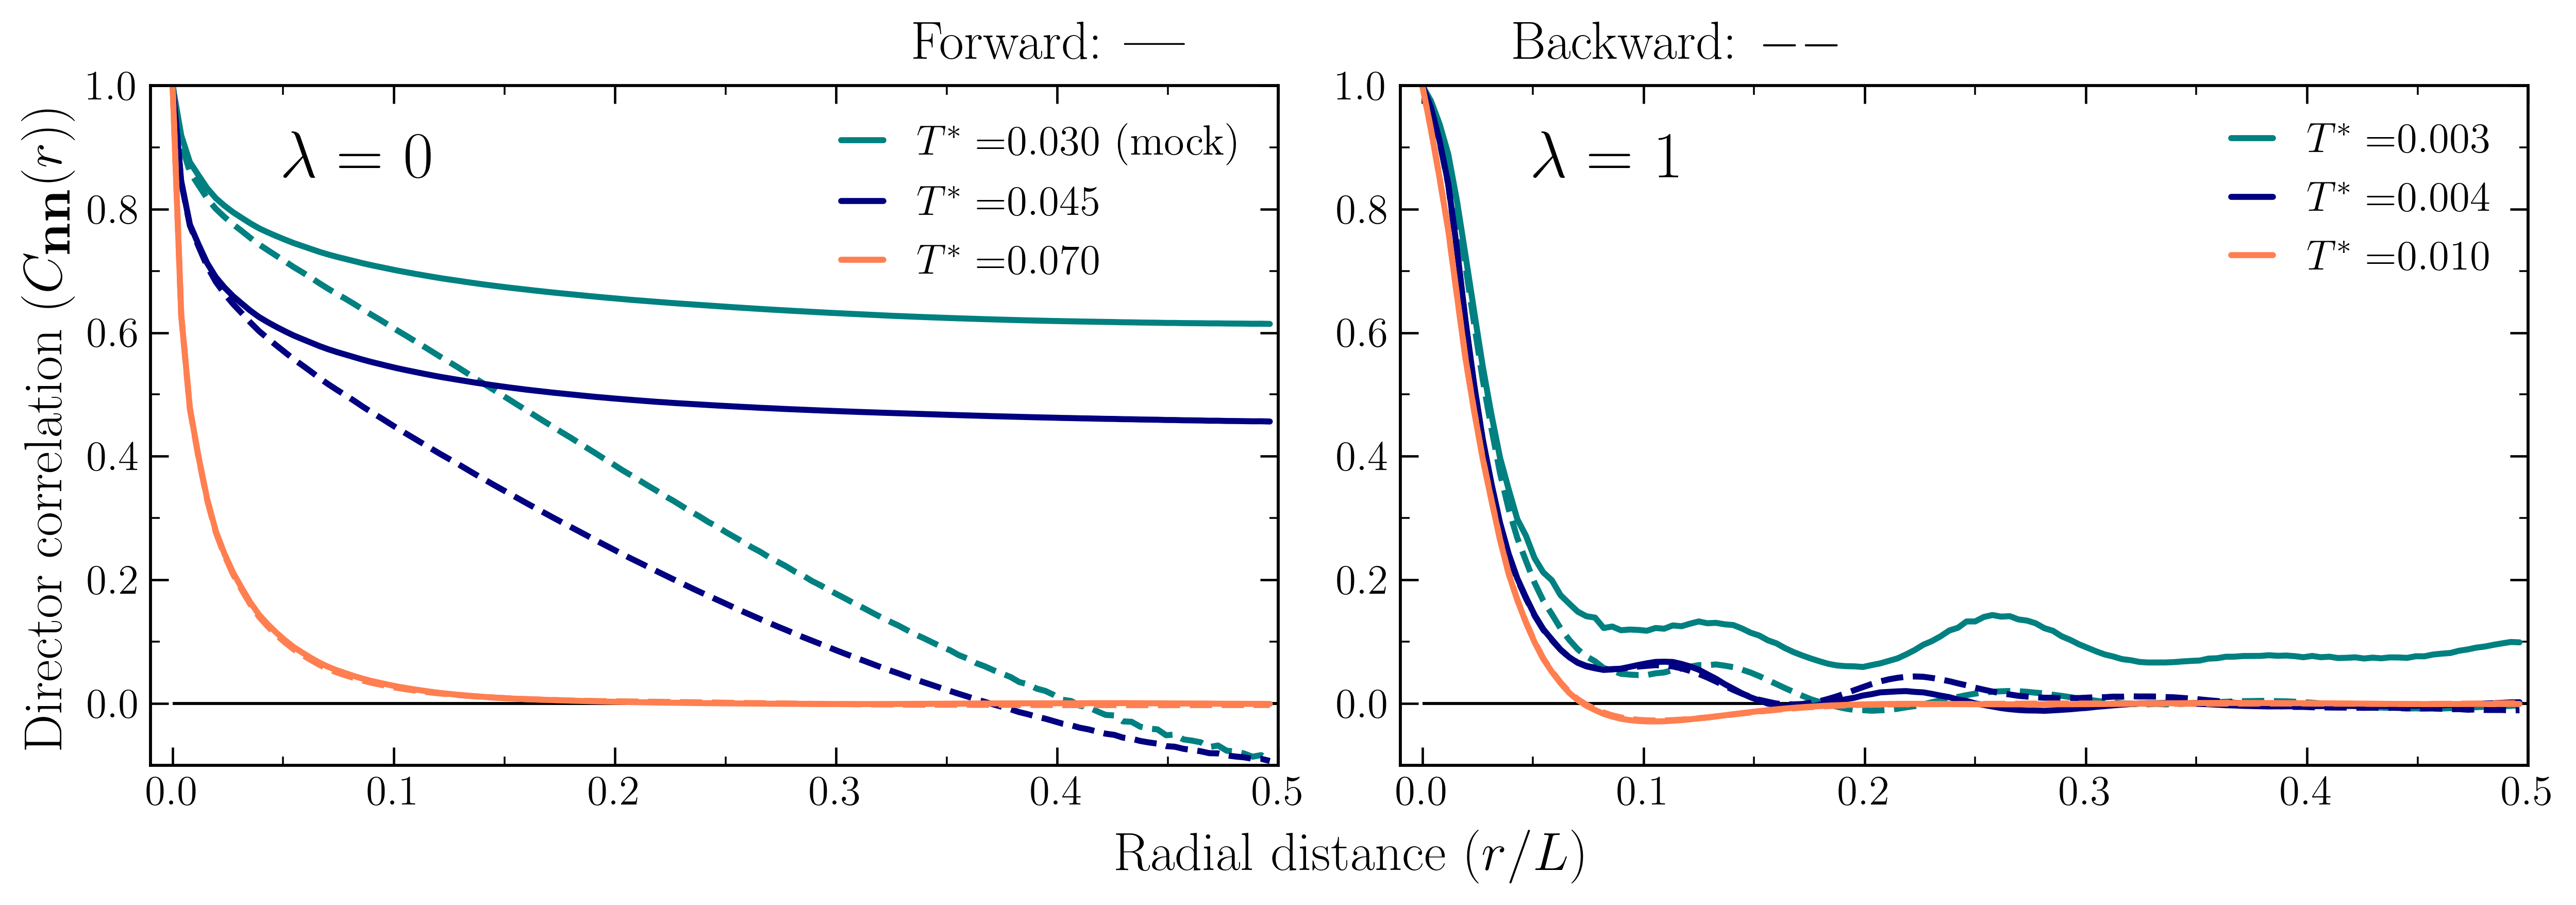

In [118]:

plt.rcParams.update({"text.usetex": True, "legend.fontsize": 14, 
                     "legend.handlelength": 0,
                     })

fig, ax = plt.subplots(ncols=2,figsize=(12, 4.5))
ax = ax.flatten()
normalize=True
marker_list = ['dotted', 'dashed', 'dashdot']
ninfo = 1000

for i, lambda_val in enumerate([0, 1]):
    mode = 'wet'
    normalizer = LX if normalize else 1
    out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}'
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_include_list = [0.03, 0.045, 0.07] if lambda_val == 0 else [.003, 0.004, 0.01]
    act_idx_fwd_include_list = [3, -6, -2,]# -1]

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    rdf_arr_av_fwd = np.load(os.path.join(out_path_fwd, 'rdf_arr_av.npy'))
    rdf_arr_av_bck = np.load(os.path.join(out_path_bck, 'rdf_arr_av.npy'))
    rvals = np.load(os.path.join(out_path_fwd, 'rvals.npy'))

    print(lambda_val, act_fwd, act_bck)

    act_bck = act_bck #[act_idx_bck_include_list]
    act_fwd = act_fwd #[act_idx_fwd_include_list]
    rdf_arr_av_fwd = rdf_arr_av_fwd #[act_idx_fwd_include_list]
    rdf_arr_av_bck = rdf_arr_av_bck #[act_idx_bck_include_list]

    if i == 0:
      
        rdf_mock = rdf_arr_av_fwd[0,0,:].astype(np.float64) 
        rdf_mock *= 1 + (rdf_mock[0] - rdf_mock) *.5
        ax[i].plot(rvals/LX, rdf_mock,'-', color=f'C{0}',  label = rf'$T^* = ${act_include_list[0]:.3f} (mock)')

    for j, act in enumerate(act_include_list):
        #act_idx_fwd = np.argwhere(act_fwd == act)[0][0]
        #act_idx_bck = np.argwhere(act_bck == act)[0][0]
        try:
            act_idx_fwd = np.argwhere(act_fwd == act)[0][0]
            ax[i].plot(rvals/LX, rdf_arr_av_fwd[act_idx_fwd, 0,:],'-', color=f'C{j}',  label = rf'$T^* = ${act:.3f}')
        except:
            pass
        try:
            act_idx_bck = np.argwhere(act_bck == act)[0][0]
            ax[i].plot(rvals/LX, rdf_arr_av_bck[act_idx_bck, 0,:],ls='dashed', color=f'C{j}',)# label = rf'$T^* = ${act:.3f}' if j==0 else None) # $~~~~~~~~~\hspace{5em}$' if i==0 else None)# label=r'$\overline{l_{perc}}$')
        except:
            pass

    ax[i].legend(fontsize=14, loc='upper right', handlelength=1, ncol=1) #if i==0 else None)
    ax[i].set_ylim([-0.1, 1])
    ax[i].set_xlim([-.01, .5])
    ax[i].hlines(0, 0, .5, color='black', lw=1, zorder=-1)
    ax[i].text(0.05, 0.85, rf'$\lambda = ~${lambda_val}', fontsize=22) # transform=ax[i].transAxes, fontsize=22)
    ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(5e-2))
ax[0].set_ylabel(r'Director correlation ($C_{\textbf{nn}} (r)$)')
fig.supxlabel(r'Radial distance ($r/L$)',x=.525,y=0.05)
#
# fig.suptitle(r'Solid: Forward ~~~~~~~~~~~~~~~~~~ Dashed: Backward', fontsize=18, x=.535,y=.935,)# bbox_to_anchor=(0.5, 1.02))#, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white')) 
fig.suptitle(r'Forward: $\textbf{---}$ ~~~~~~~~~~~~~~~~~~ Backward: $--$', fontsize=18, x=.535,y=.935,)
#ax[1].set_yscale('log')
for n, AXX in enumerate(ax):
    AXX.tick_params(axis='both',which='major', labelsize=14 if n==0 else 14)

fig.tight_layout()
save_path = os.path.join(out_path_all, 'figs')
if not os.path.isdir(save_path):
    os.makedirs(save_path)
fig.savefig(os.path.join(save_path, f'correlation.png'), dpi=520, bbox_inches='tight', pad_inches=.1)
fig.savefig(os.path.join(figpath_article, f'correlation.png'), dpi=520, bbox_inches='tight', pad_inches=.1) 

In [ ]:



for i, lambda_val in enumerate([0,]):
    mode = 'wet'
 
    out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}'
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_include_list = [0.03, 0.045, 0.07] if lambda_val == 0 else [.003, 0.004, 0.01]
    act_idx_fwd_include_list = [3, -6, -2,]# -1]

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    conv_list_bck = np.load(os.path.join(out_path_bck, 'conv_list.npy'))

    rdf_arr_fwd = np.load(os.path.join(out_path_fwd, 'rdf_arr.npy'))
    rdf_arr_bck = np.load(os.path.join(out_path_bck, 'rdf_arr.npy'))

    rnn_arr_fwd = np.load(os.path.join(out_path_fwd, 'nn_arr.npy'))
    rnn_arr_bck = np.load(os.path.join(out_path_bck, 'nn_arr.npy'))

    lmax_arr_fwd = np.load(os.path.join(out_path_fwd, 'lmax_arr.npy'))
    lmax_arr_bck = np.load(os.path.join(out_path_bck, 'lmax_arr.npy'))

    def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))
    def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))

    rdf_arr_av_fwd = np.load(os.path.join(out_path_fwd, 'rdf_arr_av.npy'))
    rdf_arr_av_bck = np.load(os.path.join(out_path_bck, 'rdf_arr_av.npy'))
    rvals = np.load(os.path.join(out_path_fwd, 'rvals.npy'))

    print(lambda_val, act_fwd, act_bck)

    act_bck = act_bck #[act_idx_bck_include_list]
    act_fwd = act_fwd #[act_idx_fwd_include_list]
    rdf_arr_av_fwd = rdf_arr_av_fwd #[act_idx_fwd_include_list]
    rdf_arr_av_bck = rdf_arr_av_bck #[act_idx_bck_include_list]

act_bck_crit = 0.045
act_bck_idx = np.argwhere(act_bck == act_bck_crit)[0][0]
print(act_bck_idx, act_bck[act_bck_idx])
plt.plot(np.nanmean(rdf_arr_bck[0:200,:,act_bck_idx],axis=0), 'x-', label='first 200')
plt.plot(np.nanmean(rdf_arr_bck[200:500,:,act_bck_idx],axis=0), 'x-', label='200-500')
plt.plot(np.nanmean(rdf_arr_bck[-500:,:,act_bck_idx],axis=0), 'x-', label='last 500')
plt.plot(np.nanmean(rdf_arr_bck[-250:,:,act_bck_idx],axis=0), 'x-', label='last 250')
plt.plot(np.nanmean(rdf_arr_bck[-150:,:,act_bck_idx],axis=0), 'x-', label='last 150')
plt.plot(np.nanmean(rdf_arr_bck[-50:,:,act_bck_idx],axis=0), 'x-', label='last 50')
plt.plot(rdf_arr_av_bck[act_bck_idx,0,:], '--', alpha=.3, label='av')
plt.legend()

In [ ]:
if mode == 'dry':
    fig, ax = plot_order_param(order_param_arr_fwd, act_fwd, Nframes, ninfo, \
                        act_idx_exclude_list = [2,4], save_path=os.path.join(fig_path, 'order_param_fwd.png'), \
                        mode = mode, direction = 'fwd', ylim=[-.1, 1.1])
    fig, ax = plot_order_param_double(order_param_arr_bck, act_bck, idx_lower = 7, \
                                Nframes = Nframes, ninfo = ninfo, \
                                act_idx_exclude_list = [6, 8, 10], \
                                save_path=os.path.join(fig_path, 'order_param_bck.png'), \
                                mode = mode, direction = 'bck', ylim_list=[[0, .3], [-.1, .35]])
if mode == 'wet' and lambda_val == 0:
    fig, ax = plot_order_param(order_param_arr_bck, act_bck, Nframes, ninfo, \
                        act_idx_exclude_list = [], lambda_val=lambda_val, save_path=os.path.join(fig_path, 'order_param_bck.png'), \
                        mode = mode, direction = 'bck', ylim=[-.1, .6])
    fig, ax = plot_order_param(order_param_arr_fwd, act_fwd, Nframes, ninfo, \
                        act_idx_exclude_list = [], lambda_val=lambda_val, save_path=os.path.join(fig_path, 'order_param_fwd.png'), \
                        mode = mode, direction = 'fwd', ylim=[-.1, 1])
if mode == 'wet' and lambda_val > 0:
    fig, ax = plot_order_param(order_param_arr_bck, act_bck, Nframes, ninfo, \
                        act_idx_exclude_list = [], lambda_val=lambda_val, save_path=os.path.join(fig_path, 'order_param_bck.png'), \
                        mode = mode, direction = 'bck', ylim=[-.3, .3])
    fig, ax = plot_order_param(order_param_arr_fwd, act_fwd, Nframes, ninfo, \
                        act_idx_exclude_list = [], lambda_val=lambda_val, save_path=os.path.join(fig_path, 'order_param_fwd.png'), \
                        mode = mode, direction = 'fwd', ylim=[-.3, .3])

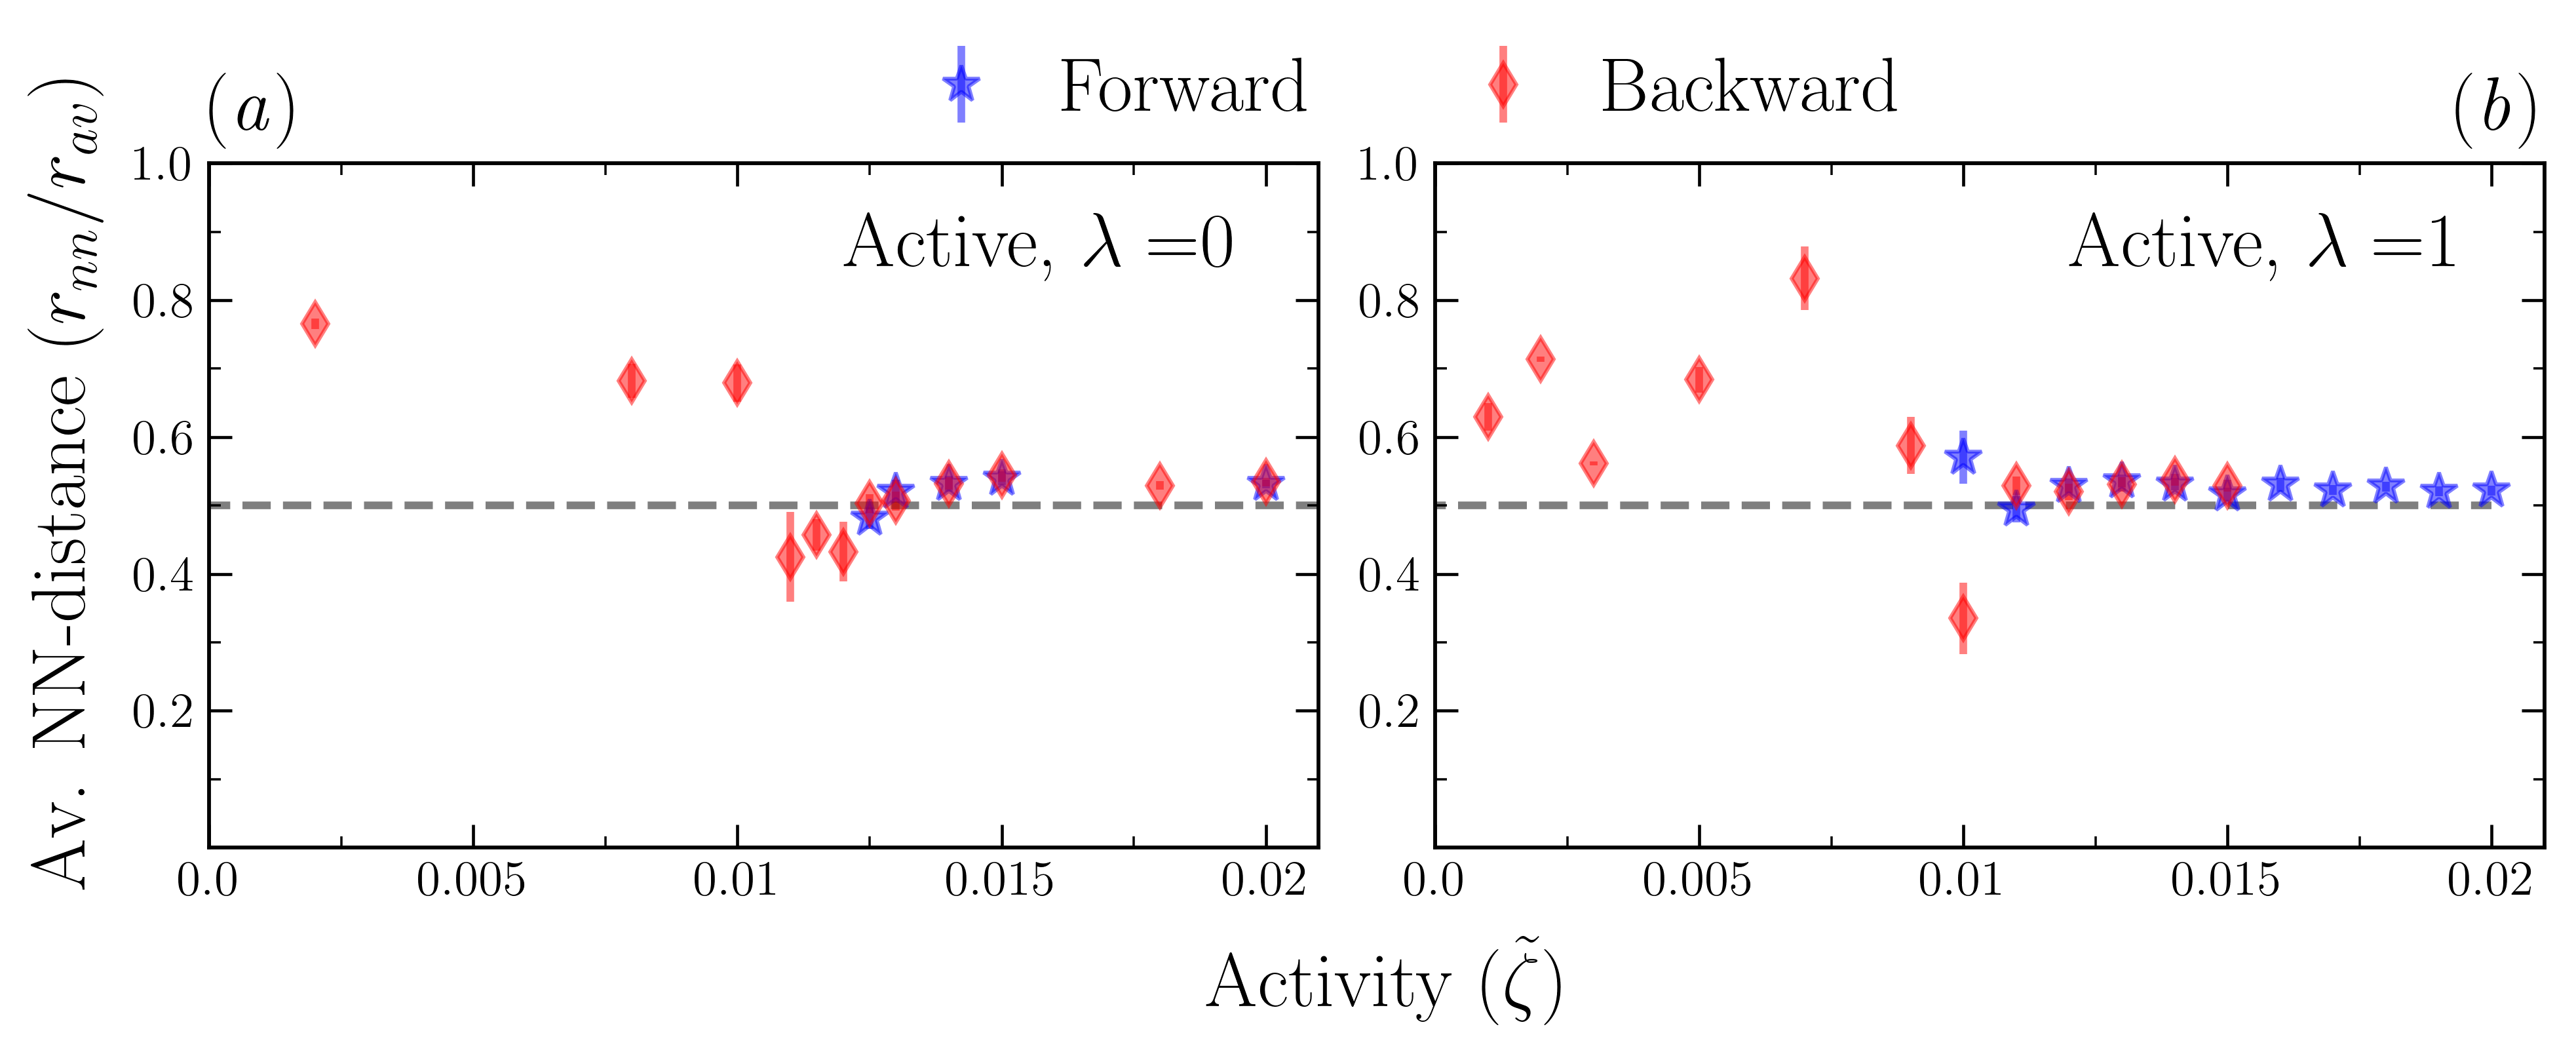

In [30]:
width=9.5
fig, ax0 = plt.subplots(ncols = 2, figsize=(width,width/2.5), dpi=420)
act_min_idx_bck = 1

if mode == 'ac':
  for i, ax in enumerate(ax0):
      lambda_val = lambda_list[i]
      #out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}'

      out_path_all = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\{folder_name}\{mode}\\na{LX}'
      out_path_main = os.path.join(out_path_all, f'{lambda_val}') 
      out_path_fwd = os.path.join(out_path_main, 'fwd')
      out_path_bck = os.path.join(out_path_main, 'bck')

      act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
      act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))

      act_bck = act_bck[act_min_idx_bck:]

      nn_arr_fwd_av = np.load(os.path.join(out_path_fwd, 'nn_av.npy'))
      nn_arr_bck_av = np.load(os.path.join(out_path_bck, 'nn_av.npy'))[act_min_idx_bck:]

      ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
      ax.xaxis.set_minor_locator(ticker.MultipleLocator(2.5e-3))

      #ax.plot(act_fwd, nn_arr_fwd_av[:,0], 'b*',alpha=.5,ms=10, label=rf'Forward' )#if i==0 else None)#$\lambda = $ {lambda_val}')# label=r'$\overline{l_{max}}$')
      xticks=[0.0, 0.005, 0.01, 0.015, 0.02]
      yticks=[0.2, 0.4, 0.6, 0.8, 1.0]
      xtick_labels=[r'~~0.0', '0.005', '0.01', '0.015', '0.02']
      ax.set_xticks(xticks, xticks)
      ax.set_yticks(yticks, yticks)

      ax.errorbar(act_fwd, nn_arr_fwd_av[:,0], yerr=nn_arr_fwd_av[:,1], fmt='b*', alpha=.5, ms=10, label=rf'Forward' if i==0 else None)#$\lambda = $ {lambda_val}')# label=r'$\overline{l_{max}}$')
      ax.errorbar(act_bck, nn_arr_bck_av[:,0], yerr=nn_arr_bck_av[:,1], fmt='rd', alpha=.5, ms=8, label=rf'Backward' if i==0 else None)# label=r'$\overline{l_{max}}$')
      #ax.plot(act_bck, nn_arr_bck_av[:,0], 'rd',alpha=.5, ms=8, label=rf'Backward' )#if i==0 else None)# label=r'$\overline{l_{max}}$')
      ax.hlines(0.5, -1, max(act_fwd[-1], act_bck[-1]), linestyle='--', color='black', alpha=0.5,
                      )#label='Uniform')# if i==0 else None) 
    #  ax.set_ylabel(r'NN-distance ($1/r_{av}$)', fontsize=20)
      #ax.set_xlabel((r'Effective Temperature ($T^*$)'), fontsize=20)
      ax.tick_params(axis='both',which='major', labelsize=13)
      ax.set_ylim((0,1))#0.8))
      ax.set_xlim((0, act_fwd[-1] + 1e-3))
      ax.text(0.012, 0.85, rf'Active, $\lambda = ${lambda_val}', fontsize=20)

  for n, AXX in enumerate(ax0):
    AXX.text(0 if n==0 else .92, 1.05, rf'$\it{{({string.ascii_lowercase[n]})}}$', transform=AXX.transAxes,
            size=20,  weight='normal',fontstyle='italic',fontfamily="Times New Roman",)
  # AXX.tick_params(axis='both',which='major', labelsize=14 if n==0 else 14)

  fig.supylabel(r'Av. NN-distance ($r_{nn}/r_{av}$)', fontsize=20, y=.57)
  fig.supxlabel((r'Activity ($\tilde\zeta$)'), fontsize=20, y=0.05, x=.54)
  #if lambda_val == 0:
  fig.legend(fontsize=20,loc='upper center', bbox_to_anchor=(0.55, 1.04), ncol=2)
  #fig.text(0.2, 0.25, rf'Active: $\lambda = ${lambda_val}', fontsize=20)
  #ax.set_ylim((0,0.7))
  fig.tight_layout() 
  fig.savefig(os.path.join(fig_path, f'rnn_{mode}.png'), dpi=520, bbox_inches='tight', pad_inches=.1) 
  fig.savefig(os.path.join(figpath_article, f'rnn_{mode}.png'), dpi=520, bbox_inches='tight', pad_inches=.1) 

In [ ]:
fig, ax = plt.subplots(figsize=(5.5,4))

for i, lambda_val in enumerate([1]):
    out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}'
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    nn_arr_fwd_av = np.load(os.path.join(out_path_fwd, 'nn_av.npy'))
    nn_arr_bck_av = np.load(os.path.join(out_path_bck, 'nn_av.npy'))

act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
act_fwd_flow = act_fwd
act_bck_flow = act_bck
conv_list_fwd = np.load(os.path.join(out_path_fwd, 'conv_list.npy'))
conv_list_bck = np.load(os.path.join(out_path_bck, 'conv_list.npy'))
nn_arr_fwd_av = np.load(os.path.join(out_path_fwd, 'nn_av.npy'))
nn_arr_bck_av = np.load(os.path.join(out_path_bck, 'nn_av.npy'))
order_param_fwd_av = np.load(os.path.join(out_path_fwd, 'order_param_av.npy'))
order_param_bck_av = np.load(os.path.join(out_path_bck, 'order_param_av.npy'))

ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1e-3 if lambda_val==1 else 1e-2))

#ax.plot(act_fwd, nn_arr_fwd_av[:,0], 'b*',alpha=.5,ms=10, label=rf'Forward' )#if i==0 else None)#$\lambda = $ {lambda_val}')# label=r'$\overline{l_{max}}$')

ax.errorbar(act_fwd, nn_arr_fwd_av[:,0], yerr=nn_arr_fwd_av[:,1], fmt='b*', alpha=.5, ms=10, label=rf'Forward' )#if i==0 else None)#$\lambda = $ {lambda_val}')# label=r'$\overline{l_{max}}$')
ax.errorbar(act_bck, nn_arr_bck_av[:,0], yerr=nn_arr_bck_av[:,1], fmt='rd', alpha=.5, ms=8, label=rf'Backward' )#if i==0 else None)# label=r'$\overline{l_{max}}$')
#ax.plot(act_bck, nn_arr_bck_av[:,0], 'rd',alpha=.5, ms=8, label=rf'Backward' )#if i==0 else None)# label=r'$\overline{l_{max}}$')
ax.hlines(0.5, 0, max(act_fwd[-1], act_bck_flow[-1]), linestyle='--', color='black', alpha=0.5,
                )#label='Uniform')# if i==0 else None) 
ax.set_ylabel(r'NN-distance ($1/r_{av}$)', fontsize=20)
ax.set_xlabel((r'Effective Temperature ($T^*$)'), fontsize=20)
ax.tick_params(axis='both',which='major', labelsize=14)

if lambda_val == 0:
    fig.legend(fontsize=20,loc='upper center', bbox_to_anchor=(0.55, 1.085), ncol=2)
fig.text(0.2, 0.25, rf'$\lambda = ${lambda_val}', fontsize=20)
ax.set_ylim((0,0.7))
fig.tight_layout()
fig.savefig(os.path.join(figpath_article, f'rnn_lambda{lambda_val}.png'), bbox_inches='tight', pad_inches=.1) 

In [ ]:
fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(14, 10))
ax = ax.flatten()
nmin_samples=20

normalize=True
for i, lambda_val in enumerate([0, .1, .5, 1]):
    normalizer = LX if normalize else 1
    out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}'
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    nn_arr_fwd_av = np.load(os.path.join(out_path_fwd, 'nn_av.npy'))
    nn_arr_bck_av = np.load(os.path.join(out_path_bck, 'nn_av.npy'))

    ax[i].errorbar(act_fwd, nn_arr_fwd_av[:,0], yerr=nn_arr_fwd_av[:,1], \
                   fmt='*', color='blue', ms=10,  alpha=0.5, label=rf'Forward' if i==0 else None)
    ax[i].errorbar(act_bck, nn_arr_bck_av[:,0], yerr=nn_arr_bck_av[:,1], \
                     fmt='d', color='red', ms=8,  alpha=0.5, label=rf'Backward' if i==0 else None)

    ax[i].text(0.8, 0.9, rf'$\lambda$ = {lambda_val}', transform=ax[i].transAxes, color='black',fontsize=20)
    ax[i].set_ylim([0, 0.7])
    ax[i].hlines(0.5, 0, max(act_fwd[-1], act_bck[-1]), linestyle='--', color='black', alpha=0.5,
                 label='Av. uniform nearest neighbor distance' if i==0 else None) 

    fig.supylabel(r'Nearest neighbor distance ($1/r_{av}$)')
    fig.supxlabel(r'Effective Temperature ($T^*$)', x=0.55, y=0.02)
    fig.legend(loc='upper center', ncol=4, fontsize=18, bbox_to_anchor=(0.5, 1.045), handlelength=1)

    save_path = os.path.join(out_path_all, 'figs')
    fig.tight_layout()
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    fig.savefig(os.path.join(save_path, f'nn_av.png'), bbox_inches='tight', pad_inches=.1) 

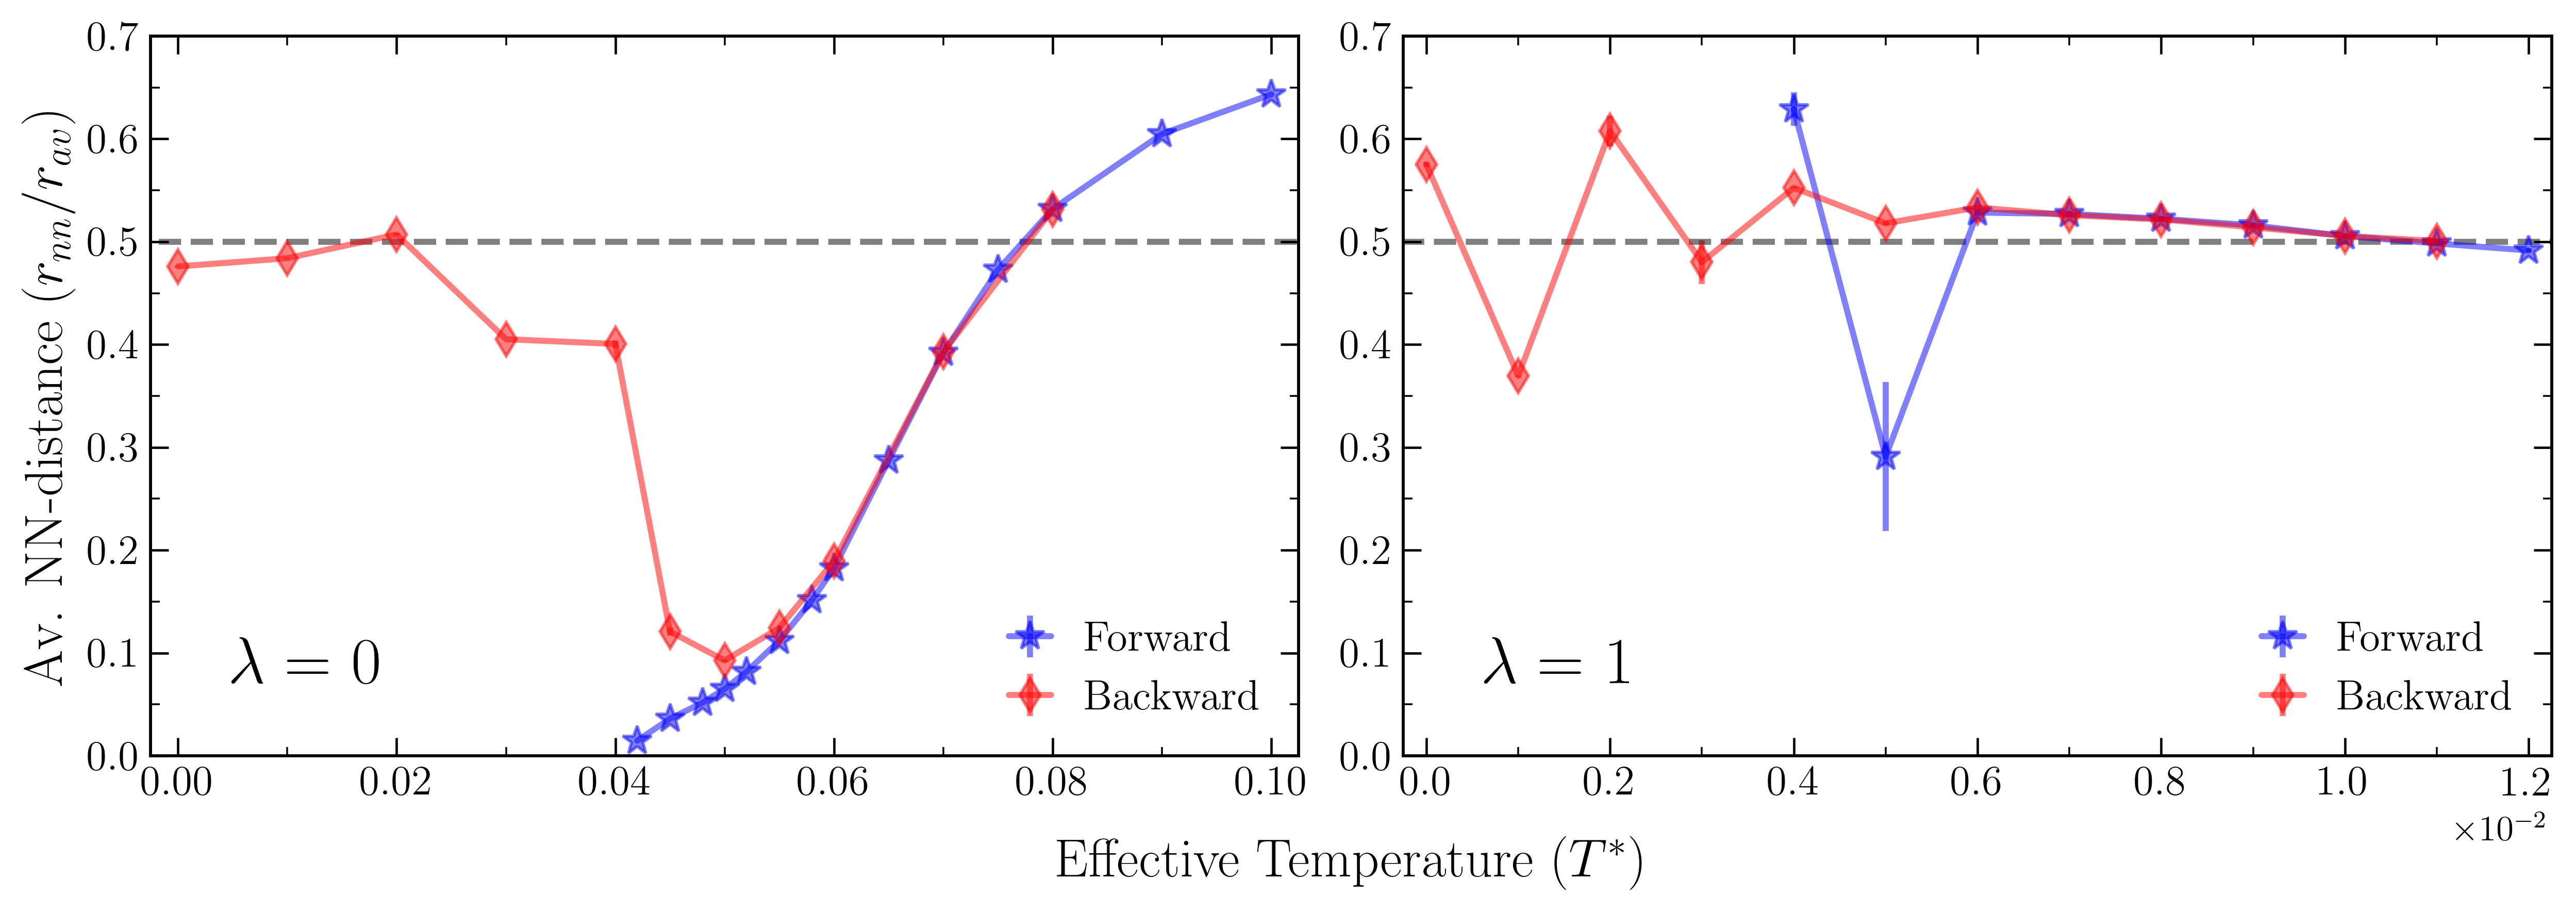

In [59]:
plt.rcParams.update({"text.usetex": True, "legend.fontsize": 14, 
                     "legend.handlelength": 0,
                     })

fig, ax = plt.subplots(ncols=2,figsize=(12, 4.5))
ax = ax.flatten()
normalize=True
marker_list = ['dotted', 'dashed', 'dashdot']
ninfo = 1000

for i, lambda_val in enumerate([0, 1]):
    mode = 'wet'
    normalizer = LX if normalize else 1
    out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}'
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
    def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))

    nn_arr_fwd = np.load(os.path.join(out_path_fwd, 'nn_arr.npy'))
    nn_arr_bck = np.load(os.path.join(out_path_bck, 'nn_arr.npy'))
    nn_arr_av_fwd = np.load(os.path.join(out_path_fwd, 'nn_av.npy'))
    nn_arr_av_bck = np.load(os.path.join(out_path_bck, 'nn_av.npy'))


    ax[i].errorbar(act_fwd, nn_arr_av_fwd[:,0], yerr=nn_arr_av_fwd[:,1], alpha=.5,ms=10,fmt='b*-', label=r'Forward')# if i==0 else None)#$\overline{l_{max}}$ (Forward)' if i==0 else None)# label=r'$\overline{l_{max}}$')
    ax[i].errorbar(act_bck, nn_arr_av_bck[:,0], yerr=nn_arr_av_bck[:,1], alpha=.5,ms=8, fmt='rd-', label=r'Backward')#  if i==0 else None) # $~~~~~~~~~\hspace{5em}$' if i==0 else None)# label=r'$\overline{l_{perc}}$')

    ax[i].set_ylim([0, .7])#0.8))
    ax[i].set_xlim([-2.5e-3 if i==0 else -2.5e-4, max(act_fwd[-1], act_bck[-1]) + 2.5e-3 if i==0 \
                    else max(act_fwd[-1], act_bck[-1]) + 2.5e-4])

  #  ax[i].set_xlabel(r'Effective Temperature ($T^*$)',)# x=1.1)
    ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(0.01 if i==0 else 0.001))
    ax[i].hlines(0.5, -.12,.12, linestyle='--', color='black', alpha=0.5,)

    ax[i].legend(fontsize=14, loc='lower right', handlelength=1, ncol=1) #if i==0 else None)
    ax[i].text(0.07, 0.1, rf'$\lambda = ~${lambda_val}', transform=ax[i].transAxes, fontsize=22)
    
    if 0:
        ###############################################################################
        xticks = [0, 2e5, 4e5, 6e5, 8e5,10e5]
        xticks_labels = ['0', '2', '4', '6', '8', '10']
        ax[2+i].set_xticks(xticks, xticks_labels)
        ax[2+i].text(0.07, 0.1, rf'$\lambda = ~${lambda_val} (Backward)', transform=ax[2+i].transAxes, fontsize=22)
        ax[2+i].set_xlim([0, 1e6])
        ax[2+i].xaxis.set_minor_locator(ticker.MultipleLocator(1e5))
        ax[2+i].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

        for j, temp in enumerate(act_bck[:3]):
            mask_bck = nn_arr_bck[:,0, j] > 0
            normalizer = LX / np.sqrt(def_arr_bck[mask_bck,j]) if normalize else 1
            xvals = np.arange(0, Nframes * ninfo, ninfo)[mask_bck]

            ax[2+i].plot(xvals, nn_arr_bck[mask_bck, 0, j] / normalizer, ls=marker_list[j], label = rf'$T^* = ${temp:.3f}')
            #ax[2+i].set_xlabel(r'Time step') # ($1/10^6$)')
            ax[2+i].set_ylim([0, 1])  

            ax[2+i].legend(ncols=3, loc='upper left',fontsize=14, handlelength=1)# if j==2 else 1)   

ax[0].set_ylabel(r'Av. NN-distance ($r_{nn}/r_{av}$)')
#ax[2].set_ylabel(r'NN-distance ($r_{nn}(t)/r_{av}(t)$)')
#fig.supxlabel(r'Time step ($10^5$)',x=.525,y=0.025)
fig.supxlabel(r'Effective Temperature ($T^*$)',x=.525,y=0.075)

for n, AXX in enumerate(ax):
    AXX.tick_params(axis='both',which='major', labelsize=14 if n==0 else 14)

fig.tight_layout()
save_path = os.path.join(out_path_all, 'figs')
if not os.path.isdir(save_path):
    os.makedirs(save_path)
fig.savefig(os.path.join(save_path, f'rnn_av.png'), dpi=520, bbox_inches='tight', pad_inches=.1)
fig.savefig(os.path.join(figpath_article, f'rnn_av.png'), dpi=520, bbox_inches='tight', pad_inches=.1) 

In [ ]:
plt.rcParams.update({"text.usetex": True, "legend.fontsize": 14, 
                     "legend.handlelength": 0,
                     })

fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(12, 8))
ax = ax.flatten()
normalize=True
marker_list = ['dotted', 'dashed', 'dashdot']
ninfo = 1000

for i, lambda_val in enumerate([0, 1]):
    mode = 'wet'
    normalizer = LX if normalize else 1
    out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}'
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
    def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))

    nn_arr_fwd = np.load(os.path.join(out_path_fwd, 'nn_arr.npy'))
    nn_arr_bck = np.load(os.path.join(out_path_bck, 'nn_arr.npy'))
    nn_arr_av_fwd = np.load(os.path.join(out_path_fwd, 'nn_av.npy'))
    nn_arr_av_bck = np.load(os.path.join(out_path_bck, 'nn_av.npy'))


    ax[i].errorbar(act_fwd, nn_arr_av_fwd[:,0], yerr=nn_arr_av_fwd[:,1], alpha=.5,ms=10,fmt='b*-', label=r'Forward')# if i==0 else None)#$\overline{l_{max}}$ (Forward)' if i==0 else None)# label=r'$\overline{l_{max}}$')
    ax[i].errorbar(act_bck, nn_arr_av_bck[:,0], yerr=nn_arr_av_bck[:,1], alpha=.5,ms=8, fmt='rd-', label=r'Backward')#  if i==0 else None) # $~~~~~~~~~\hspace{5em}$' if i==0 else None)# label=r'$\overline{l_{perc}}$')

    ax[i].set_ylim([0, .7])#0.8))
    ax[i].set_xlim([-2.5e-3 if i==0 else -2.5e-4, max(act_fwd[-1], act_bck[-1]) + 2.5e-3 if i==0 \
                    else max(act_fwd[-1], act_bck[-1]) + 2.5e-4])

  #  ax[i].set_xlabel(r'Effective Temperature ($T^*$)',)# x=1.1)
    ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(0.01 if i==0 else 0.001))
    ax[i].hlines(0.5, -.12,.12, linestyle='--', color='black', alpha=0.5,)

    ax[i].legend(fontsize=14, loc='lower right', handlelength=1, ncol=1) #if i==0 else None)
    ax[i].text(0.07, 0.1, rf'$\lambda = ~${lambda_val}', transform=ax[i].transAxes, fontsize=22)
    
    ###############################################################################
    xticks = [0, 2e5, 4e5, 6e5, 8e5,10e5]
    xticks_labels = ['0', '2', '4', '6', '8', '10']
    ax[2+i].set_xticks(xticks, xticks_labels)
    ax[2+i].text(0.07, 0.1, rf'$\lambda = ~${lambda_val} (Backward)', transform=ax[2+i].transAxes, fontsize=22)
    ax[2+i].set_xlim([0, 1e6])
    ax[2+i].xaxis.set_minor_locator(ticker.MultipleLocator(1e5))
    ax[2+i].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

    for j, temp in enumerate(act_bck[:3]):
        mask_bck = nn_arr_bck[:,0, j] > 0
        normalizer = LX / np.sqrt(def_arr_bck[mask_bck,j]) if normalize else 1
        xvals = np.arange(0, Nframes * ninfo, ninfo)[mask_bck]

        ax[2+i].plot(xvals, nn_arr_bck[mask_bck, 0, j] / normalizer, ls=marker_list[j], label = rf'$T^* = ${temp:.3f}')
        #ax[2+i].set_xlabel(r'Time step') # ($1/10^6$)')
        ax[2+i].set_ylim([0, 1])  

        ax[2+i].legend(ncols=3, loc='upper left',fontsize=14, handlelength=1)# if j==2 else 1)   
ax[0].set_xlabel('')
ax[0].set_ylabel(r'Av. NN-distance ($r_{nn}/r_{av}$)')
ax[2].set_ylabel(r'NN-distance ($r_{nn}(t)/r_{av}(t)$)')
fig.supxlabel(r'Time step ($10^5$)',x=.525,y=0.025)
fig.text(0.525, 0.525, r'Effective Temperature ($T^*$)', ha='center', va='bottom',fontsize=20)
labels = []
handles = []

for errorbar in ax[0].containers:  # Accessing all the containers (including ErrorbarContainer)
    labels.append(errorbar.get_label())
    handles.append(errorbar)

for n, AXX in enumerate(ax):
    AXX.tick_params(axis='both',which='major', labelsize=14 if n==0 else 14)

fig.tight_layout()
save_path = os.path.join(out_path_all, 'figs')
if not os.path.isdir(save_path):
    os.makedirs(save_path)
#fig.savefig(os.path.join(save_path, f'rnn_superfig.png'), dpi=520, bbox_inches='tight', pad_inches=.1)
#fig.savefig(os.path.join(figpath_article, f'rnn_superfig.png'), dpi=520, bbox_inches='tight', pad_inches=.1) 

In [ ]:
for i, lambda_val in enumerate([1,]):
    mode = 'wet'
    normalizer = LX if normalize else 1
    out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}'
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    lmax_av_fwd = np.load(os.path.join(out_path_fwd, 'lmax_av.npy')) / normalizer
    lperc_av_fwd = np.load(os.path.join(out_path_fwd, 'lperc_av.npy')) / normalizer
    lmax_av_bck = np.load(os.path.join(out_path_bck, 'lmax_av.npy')) / normalizer
    lperc_av_bck = np.load(os.path.join(out_path_bck, 'lperc_av.npy')) / normalizer
    nn_arr_fwd = np.load(os.path.join(out_path_fwd, 'nn_arr.npy'))
    nn_arr_bck = np.load(os.path.join(out_path_bck, 'nn_arr.npy'))
    def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
    def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))

    j = 1
    mask_bck = nn_arr_bck[:,0, j] > 0
    print(mask_bck.sum())
    normalizer = LX / np.sqrt(def_arr_bck[mask_bck,j]) if normalize else 1

    print(conv_list_bck)
def_arr_bck.shape, act_bck.shape, nn_arr_bck.shape
plt.plot(nn_arr_bck[:,0,j]/normalizer)

In [ ]:
fig, ax0 = plt.subplots(ncols=2,figsize=(8,4.5))


for j, ax in enumerate(ax0):
    lambda_val = lambda_list[j]

    out_path_all = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\{folder_name}\{mode}\\na{LX}'
    out_path_main = os.path.join(out_path_all, f'{lambda_val}') 

    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')
    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    order_param_fwd_av = np.load(os.path.join(out_path_fwd, 'order_param_av.npy'))
    order_param_bck_av = np.load(os.path.join(out_path_bck, 'order_param_av.npy'))


    ax.errorbar(act_fwd, order_param_fwd_av[:,0], yerr=order_param_fwd_av[:,1], fmt='o-', color='blue',  alpha=0.5, label='forward')
    ax.errorbar(act_bck, order_param_bck_av[:,0], yerr=order_param_bck_av[:,1], fmt='s-', color='red',  alpha=0.5, label='backward')
    ax.legend(fontsize=12)
    ax.set_ylim([-.3, .3])
    ax.set_title(rf'Active ($\lambda$ = {lambda_val})') 

if 0:
    for i, AXX in enumerate(ax0):
        if mode == 'dry':
            AXX.vlines(0.11, 0, 1, linestyle='--', color='black', alpha=0.5,)
            AXX.vlines(0.18, 0, 1, linestyle='--', color='black', alpha=0.5,)
            AXX.vlines(0.3, 0, 1, linestyle='--', color='black', alpha=0.5,)
            AXX.set_ylim([-.3, .3])
fig.supylabel('Order parameter (S)')
fig.supxlabel('Effective Temperature ($T^*$)', y=0.065)
fig.tight_layout()
#fig.savefig(os.path.join(fig_path, f'order_param_av_act.png'), dpi=520, bbox_inches='tight', pad_inches=.1) 

In [ ]:
LX = 256
mode = 'wet'
folder_name = 'diff_lambda_periodic' if mode == 'wet' else 'dry_periodic_long'
lambda_list=[0,1]
#lambda_list = [0,]# .8] # [0, .1, .5, .8, 1]   # .1, .5, .8] # .5, .8]#, 0.1, 0.5, 0.8]

out_path_all = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\{folder_name}\{mode}\\na{LX}'
out_dry= 'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\dry_periodic\\dry\\na256\\1'

outdir_list = []
title_list = []
outdir_list.append(out_dry)
title_list.append('Dry')
for lambda_val in lambda_list:
    outdir_list.append(os.path.join(out_path_all, f'{lambda_val}')) #if mode == 'wet' else out_path_all)
    title_list.append(f'Wet ($\lambda$ = {lambda_val})')

fig, ax0 = plt.subplots(ncols=3,figsize=(12,4.5))

for j, ax in enumerate(ax0):
    out_path_bck = os.path.join(outdir_list[j], 'bck')
    out_path_fwd = os.path.join(outdir_list[j], 'fwd')


    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    order_param_fwd_av = np.load(os.path.join(out_path_fwd, 'order_param_av.npy'))
    order_param_bck_av = np.load(os.path.join(out_path_bck, 'order_param_av.npy'))


    ax.errorbar(act_fwd, order_param_fwd_av[:,0], yerr=order_param_fwd_av[:,1], fmt='o-', color='blue',  alpha=0.5, label='forward')
    ax.errorbar(act_bck, order_param_bck_av[:,0], yerr=order_param_bck_av[:,1], fmt='s-', color='red',  alpha=0.5, label='backward')
    ax.legend(fontsize=12)
    ax.set_title(title_list[j]) 

if 0:
    for i, AXX in enumerate(ax0):
        if mode == 'dry':
            AXX.vlines(0.11, 0, 1, linestyle='--', color='black', alpha=0.5,)
            AXX.vlines(0.18, 0, 1, linestyle='--', color='black', alpha=0.5,)
            AXX.vlines(0.3, 0, 1, linestyle='--', color='black', alpha=0.5,)
            AXX.set_ylim([-.05, .9 if i == 0 else .75])
fig.supylabel('Order parameter (S)')
fig.supxlabel('Effective Temperature ($T^*$)', y=0.065)
fig.tight_layout()
fig.savefig(os.path.join(figpath_article, f'order_param_av.png'), dpi=520, bbox_inches='tight', pad_inches=.1) 

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_14476\3607424006.py:27: RuntimeWarning: divide by zero encountered in divide
  rel_diff_fwd = np.abs(np.diff(def_arr_fwd, axis=0)) / def_arr_fwd[:-1]
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_14476\3607424006.py:27: RuntimeWarning: invalid value encountered in divide
  rel_diff_fwd = np.abs(np.diff(def_arr_fwd, axis=0)) / def_arr_fwd[:-1]


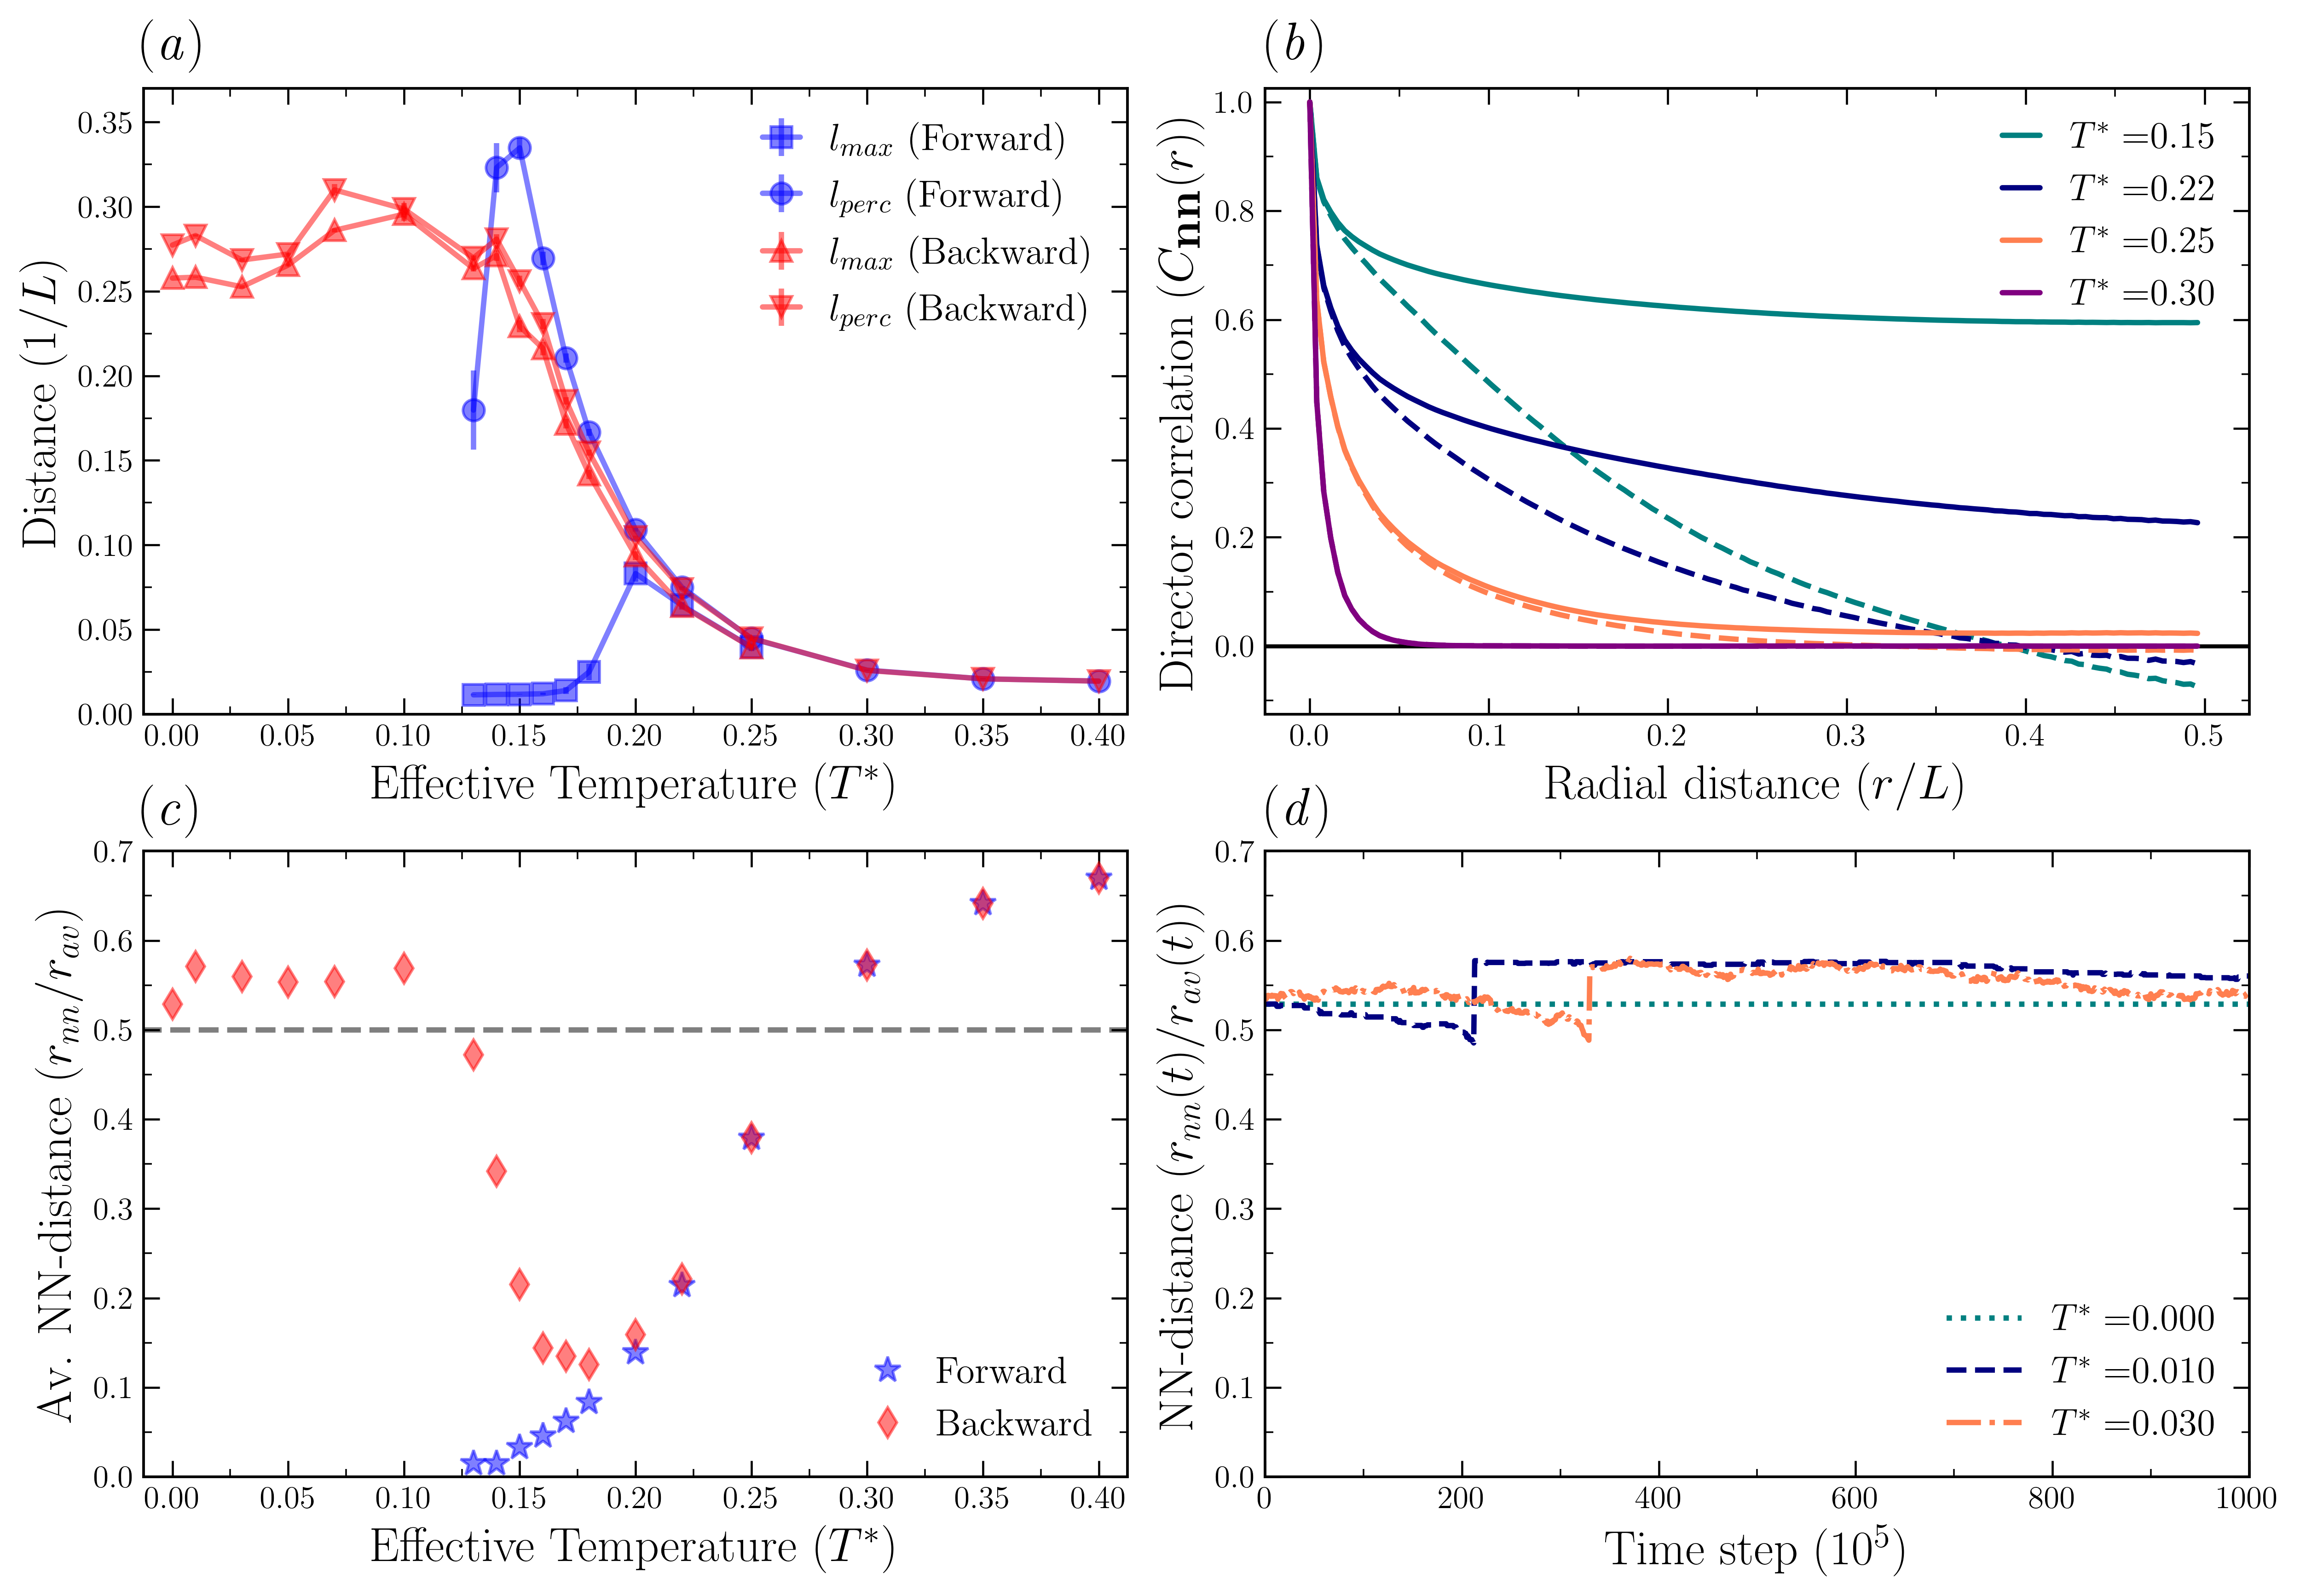

In [32]:
plt.rcParams.update({"text.usetex": True, "legend.fontsize": 14})
marker_list = ['dotted', 'dashed', 'dashdot']
if mode == 'dry':

    fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(12, 8))
    ax = ax.flatten()

    normalize=True
    nmin_samples=5
    normalizer = LX if normalize else 1

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    conv_list_fwd = np.load(os.path.join(out_path_fwd, 'conv_list.npy'))
    conv_list_bck = np.load(os.path.join(out_path_bck, 'conv_list.npy'))
    def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))
    def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
    lmax_av_fwd = np.load(os.path.join(out_path_fwd, 'lmax_av.npy')) / normalizer
    lperc_av_fwd = np.load(os.path.join(out_path_fwd, 'lperc_av.npy')) / normalizer
    lmax_av_bck = np.load(os.path.join(out_path_bck, 'lmax_av.npy')) / normalizer
    lperc_av_bck = np.load(os.path.join(out_path_bck, 'lperc_av.npy')) / normalizer
    
    rvals = np.load(os.path.join(out_path_fwd, 'rvals.npy'))
    rdf_arr_av_bck = np.load(os.path.join(out_path_bck, 'rdf_arr_av.npy'))
    rdf_arr_av_fwd = np.load(os.path.join(out_path_fwd, 'rdf_arr_av.npy'))

    rel_diff_fwd = np.abs(np.diff(def_arr_fwd, axis=0)) / def_arr_fwd[:-1]
    rel_diff_bck = np.abs(np.diff(def_arr_bck, axis=0)) / def_arr_bck[:-1]

    rel_diff_fwd_av = np.nanmean(rel_diff_fwd, axis=0)
    rel_diff_fwd_std = np.nanstd(rel_diff_fwd, axis=0) / np.sqrt(rel_diff_fwd.shape[0])
    rel_diff_bck_av = np.nanmean(rel_diff_bck, axis=0)
    rel_diff_bck_std = np.nanstd(rel_diff_bck, axis=0) / np.sqrt(rel_diff_bck.shape[0])

    

    nn_arr_fwd = np.load(os.path.join(out_path_fwd, 'nn_arr.npy'))
    nn_arr_bck = np.load(os.path.join(out_path_bck, 'nn_arr.npy'))

    nn_arr_fwd_av = np.load(os.path.join(out_path_fwd, 'nn_av.npy'))
    nn_arr_bck_av = np.load(os.path.join(out_path_bck, 'nn_av.npy'))
    nn_arr_fwd_weighted_av = np.nan * np.zeros((len(act_fwd),2))

    ax[2].plot(act_fwd, nn_arr_fwd_av[:,0], 'b*',alpha=.5,ms=10, label=rf'Forward' )#if i==0 else None)#$\lambda = $ {lambda_val}')# label=r'$\overline{l_{max}}$')
    ax[2].plot(act_bck, nn_arr_bck_av[:,0], 'rd',alpha=.5, ms=8, label=rf'Backward' )#if i==0 else None)# label=r'$\overline{l_{max}}$')
    ax[2].hlines(0.5, -.1, max(act_fwd[-1], act_bck[-1])+.1, linestyle='--', color='black', alpha=0.5,
                    )#label='Uniform')# if i==0 else None) 
    ax[2].set_ylabel(r'Av. NN-distance ($r_{nn}/r_{av}$)')
    ax[2].set_xlabel((r'Effective Temperature ($T^*$)'))
    ax[2].set_ylim([0, .7])
    ax[2].set_xlim(([-0.0125, 0.4125]))
    ax[2].legend(loc='lower right')

    # ------------------------------------
    ax[0].errorbar(act_fwd, lmax_av_fwd[:,0], yerr=lmax_av_fwd[:,1], alpha=.5,ms=8,fmt='bs-', label=r'$l_{max}$ (Forward)')# label=r'$\overline{l_{max}}$')
    ax[0].errorbar(act_fwd, lperc_av_fwd[:,0], yerr=lperc_av_fwd[:,1], alpha=.5,ms=8, fmt='o-',color='blue', label=r'$l_{perc}$ (Forward)')# label=r'$\overline{l_{perc}}$')
    ax[0].errorbar(act_bck, lmax_av_bck[:,0], yerr=lmax_av_bck[:,1], alpha=.5, ms=8,fmt='r^-', label=r'$l_{max}$ (Backward)')# label=r'$\overline{l_{max}}$')
    ax[0].errorbar(act_bck, lperc_av_bck[:,0], yerr=lperc_av_bck[:,1], ms=8,alpha=.5,fmt='rv-', label=r'$l_{perc}$ (Backward)')# label=r'$\overline{l_{perc}}$')
    ax[0].set_xlabel(r'Effective Temperature ($T^*$)')
    ax[0].set_ylabel(r'Distance ($1/L$)')
    ax[0].legend()
    ax[0].set_ylim([0, .37])
    ax[0].set_xlim(([-0.0125, 0.4125]))

    # ------------------------------------
    act_include_list = [.15, .22, .25, .30]

 #   ax[1].errorbar(act_fwd, rel_diff_fwd_av[:len(act_fwd)], yerr=rel_diff_fwd_std[:len(act_fwd)], alpha=.5,ms=10,fmt='bo-', label=rf'Forward')#$\lambda = $ {lambda_val}')# label=r'$\overline{l_{max}}$')
  #  ax[1].errorbar(act_bck, rel_diff_bck_av[:len(act_bck)], yerr=rel_diff_bck_std[:len(act_bck)], alpha=.5, ms=10,fmt='ro-', label=rf'Backward')# label=r'$\overline{l_{max}}$')
   # ax[1].set_ylabel(r'$\langle[[N(t+1)-N(t)] / N(t)] \rangle$')
    ax[1].set_xlabel((r'Radial distance ($r/L$)'))

    ax[1].set_ylabel(r'Director correlation ($C_{\textbf{nn}} (r)$)')

    for j, act in enumerate(act_include_list):
        #act_idx_fwd = np.argwhere(act_fwd == act)[0][0]
        #act_idx_bck = np.argwhere(act_bck == act)[0][0]
        try:
            act_idx_fwd = np.argwhere(act_fwd == act)[0][0]
            ax[1].plot(rvals/LX, rdf_arr_av_fwd[act_idx_fwd, 0,:],'-', color=f'C{j}',  label = rf'$T^* = ${act:.2f}')
        except:
            pass
        try:
            act_idx_bck = np.argwhere(act_bck == act)[0][0]
            ax[1].plot(rvals/LX, rdf_arr_av_bck[act_idx_bck, 0,:],ls='dashed', color=f'C{j}',)# label = rf'$T^* = ${act:.3f}' if j==0 else None) # $~~~~~~~~~\hspace{5em}$' if i==0 else None)# label=r'$\overline{l_{perc}}$')
        except:
            pass

    ax[1].legend(loc='upper right', handlelength=1, ncol=1) #if i==0 else None)
    ax[1].set_xlim([-.025,.525])
    ax[1].set_ylim([-.125, 1.025])
    ax[1].hlines(0, -.1, .6, linestyle='-', lw=1.5, color='black', alpha=1,zorder=-1)
    # ------------------------------------

    ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(0.025))
    ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(0.025))

    ax[1].xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    ax[1].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

    ax[2].xaxis.set_minor_locator(ticker.MultipleLocator(0.025))
    ax[2].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))

    ax[3].xaxis.set_minor_locator(ticker.MultipleLocator(100))
    ax[3].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    #ax[3].set_ylim([-0.05,1])
    ax[3].set_ylim([.0, .7])
    ax[3].set_xlim((0, Nframes))
   # ax[3].hlines(0.5, 0, Nframes, linestyle='--', color='black', alpha=0.5,)
                    #label='Uniform nearest neighbor distance' if i==0 else None) 
 

    for j, T in enumerate(act_bck[:3]):
        mask_bck = nn_arr_bck[:,0, j] > 0
        normalizer = LX / np.sqrt(def_arr_bck[mask_bck,j]) if normalize else 1

        if mask_bck.sum() < nmin_samples: 
            print(f'Not enough samples for {T}')
            continue


        ax[3].plot(np.arange(Nframes)[mask_bck], nn_arr_bck[mask_bck, 0, j] / normalizer, ls=marker_list[j],
                    label = rf'$T^* = ${T:.3f}')
    ax[3].legend(handlelength=2, ncols=1, loc='lower right')

    ax[3].set_ylabel(r'NN-distance ($r_{nn}(t)/r_{av}(t)$)')
    ax[3].set_xlabel((r'Time step ($10^5$)'))
                

    for n, AXX in enumerate(ax):
        fig.text(0.065 if n%2==0 else 0.55, 1.0 if n<2 else 0.505, rf'$\it{{({string.ascii_lowercase[n]})}}$',# transform=AXX.transAxes,
                size=20,  weight='normal',fontstyle='italic',fontfamily="Times New Roman",)
    
    #fig.suptitle('Results for dry case')
    save_path = os.path.join(out_path_all, 'figs')
    fig.tight_layout()
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    fig.savefig(os.path.join(save_path, f'dry_superfig.png'), bbox_inches='tight', pad_inches=.1, dpi=520)
    fig.savefig(os.path.join(figpath_article, f'dry_superfig.png'), bbox_inches='tight', pad_inches=.1, dpi=520) 

In [24]:
save_path,fig_path

('C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\dry_periodic_long\\dry\\na256\\figs',
 'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\dry_periodic_long\\dry\\na256\\1\\figs')

In [ ]:
fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(14, 10))
ax = ax.flatten()
normalize=True
for i, lambda_val in enumerate([0,.1,.5,1]):
    mode = 'wet'
    normalizer = LX if normalize else 1
    out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}'
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    lmax_av_fwd = np.load(os.path.join(out_path_fwd, 'lmax_av.npy')) / normalizer
    lperc_av_fwd = np.load(os.path.join(out_path_fwd, 'lperc_av.npy')) / normalizer
    lmax_av_bck = np.load(os.path.join(out_path_bck, 'lmax_av.npy')) / normalizer
    lperc_av_bck = np.load(os.path.join(out_path_bck, 'lperc_av.npy')) / normalizer


    ax[i].errorbar(act_fwd, lmax_av_fwd[:,0], yerr=lmax_av_fwd[:,1], alpha=.5,ms=10,fmt='b*-', label=r'$\overline{l_{max}}$ (Forward)' if i==0 else None)# label=r'$\overline{l_{max}}$')
    ax[i].errorbar(act_fwd, lperc_av_fwd[:,0], yerr=lperc_av_fwd[:,1], alpha=.5,ms=8, fmt='d-',color='blue', label=r'$\overline{l_{perc}}$ (Forward)' if i==0 else None)# label=r'$\overline{l_{perc}}$')
    #ax[0].title.set_text('Forward')
    #ax[0].legend()  

    ax[i].errorbar(act_bck, lmax_av_bck[:,0], yerr=lmax_av_bck[:,1], alpha=.5, ms=10,fmt='r*-', label=r'$\overline{l_{max}}$ (Backward)' if i==0 else None)# label=r'$\overline{l_{max}}$')
    ax[i].errorbar(act_bck, lperc_av_bck[:,0], yerr=lperc_av_bck[:,1], ms=8,alpha=.5,fmt='rd-', label=r'$\overline{l_{perc}}$ (Backward)' if i==0 else None)# label=r'$\overline{l_{perc}}$')

    #ax[i].legend()
    ax[i].set_xlabel(r'Effective Temperature ($T^*$)')
    ax[i].set_ylabel(r'Distance ($1/L$)')
    ax[i].text(0.8, 0.9, rf'$\lambda$ = {lambda_val}', transform=ax[i].transAxes, color='black',fontsize=20)
    fig.legend(loc='upper center', ncol=4, fontsize=18, bbox_to_anchor=(0.5, 1.045))
    #fig.supxlabel(r'Effective Temperature ($T^*$)', x=0.55, y=0.05)
    save_path = os.path.join(out_path_all, 'figs')
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    fig.savefig(os.path.join(save_path, f'lmax_lperc_{mode}.png'), bbox_inches='tight', pad_inches=.1) 

In [ ]:
Nframes=400
act_idx_min=0

for i, lambda_val in enumerate([0, .1, .5, 1]):

    out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}'
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))

    fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(10,10))
    ax = ax.flatten()

    #adder = 1 if lambda_val == 0.5 else 0
    adder=0
    fig.suptitle(rf'$\lambda$ = {lambda_val}',y=0.94)

    for j, T in enumerate(act_bck[act_idx_min + adder:act_idx_min + 4 + adder]):
     
        suffi='2' if lambda_val == 1 else ''
        path_bck = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\jayeeta\\diff_lambda2\\wet\\na256\\{lambda_val}\\bck\\wet-ps-{T}-out{suffi}\\defect_positions.pkl'

        defect_dict = pickle.load(open(path_bck, 'rb'))
        ax[j].set_aspect('equal')
        ax[j].set_xlim([0, 256])
        ax[j].set_ylim([0, 256])
        ax[j].xaxis.set_ticks_position('none') 
        ax[j].yaxis.set_ticks_position('none')
   

        for k, defects in enumerate(defect_dict[-Nframes:]):
            def_arr=get_defect_arr_from_frame(defects, return_charge = True) #True)
            plus_mask = def_arr[:,2] > 0

            ax[j].scatter(def_arr[plus_mask,0], def_arr[plus_mask,1], alpha=.5,s=1,
                    label=f'Frame {k}', marker='+', color='red')
            ax[j].scatter(def_arr[~plus_mask,0], def_arr[~plus_mask,1], alpha=.5,s=1,
                        label=f'Frame {k}', marker='x', color='blue')
            ax[j].set_title(rf'$T^*$ = {T}')
            
    fig_path = os.path.join(out_path_main, 'figs')
    fig.savefig(os.path.join(fig_path, f'defects_last{Nframes}_frames_to{T}.png'), bbox_inches='tight', pad_inches=.1)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
ax = ax.flatten()
normalize=True
for i, lambda_val in enumerate([1]): #0,.1,.5,1]):
    normalizer = LX if normalize else 1
   # out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}'
    #out_path_fwd = os.path.join(out_path_main, 'fwd')
    #out_path_bck = os.path.join(out_path_main, 'bck')

    #act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    #act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    nn_arr_fwd = np.load(os.path.join(out_path_fwd, 'nn_arr.npy'))
    nn_arr_bck = np.load(os.path.join(out_path_bck, 'nn_arr.npy'))


    ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax[i].set_ylim([-0.05,1])
    #ax[i].text(0.1, 0.9, rf'$\lambda$ = {lambda_val}', transform=ax[i].transAxes, color='black',fontsize=20)
    ax[i].hlines(0.5, 0, 1000, linestyle='--', color='black', alpha=0.5,)
                 #label='Uniform nearest neighbor distance' if i==0 else None) 
    

    for j, T in enumerate(act_bck[:3]):
        mask_bck = nn_arr_bck[:,0, j] > 0
        normalizer = LX / np.sqrt(def_arr_bck[mask_bck,j]) if normalize else 1

        if mask_bck.sum() < 20: continue

        ax[i].plot(np.arange(Nframes)[mask_bck], nn_arr_bck[mask_bck, 0, j] / normalizer, label = rf'$T^* = ${T:.3f}')
    ax[i].legend(handlelength=1)

fig.supylabel(r'Nearest neighbor distance ($1/r_{av}$)')
fig.supxlabel('Time step', x=.525)

if not os.path.isdir(save_path):
    os.makedirs(save_path)

fig.savefig(os.path.join(save_path, f'nn_over_time.png')) 

In [1]:
plt.rcParams.update({"text.usetex": True, "legend.fontsize": 14, 
                     "legend.handlelength": 0,
                     })

fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(12, 8))
ax = ax.flatten()
normalize=True
marker_list = ['dotted', 'dashed', 'dashdot']

for i, lambda_val in enumerate([0, 1]):
    mode = 'wet'
    normalizer = LX if normalize else 1
    out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}'
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    lmax_av_fwd = np.load(os.path.join(out_path_fwd, 'lmax_av.npy')) / normalizer
    lperc_av_fwd = np.load(os.path.join(out_path_fwd, 'lperc_av.npy')) / normalizer
    lmax_av_bck = np.load(os.path.join(out_path_bck, 'lmax_av.npy')) / normalizer
    lperc_av_bck = np.load(os.path.join(out_path_bck, 'lperc_av.npy')) / normalizer
    nn_arr_fwd = np.load(os.path.join(out_path_fwd, 'nn_arr.npy'))
    nn_arr_bck = np.load(os.path.join(out_path_bck, 'nn_arr.npy'))
    def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
    def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))


    ax[i].errorbar(act_fwd, lmax_av_fwd[:,0], yerr=lmax_av_fwd[:,1], alpha=.5,ms=8,fmt='bs-', label=r'$\overline{l_{max}}$ (Forward)' if i==0 else None)# label=r'$\overline{l_{max}}$')
    ax[i].errorbar(act_fwd, lperc_av_fwd[:,0], yerr=lperc_av_fwd[:,1], alpha=.5,ms=8, fmt='o-',color='blue', label=r'$\overline{l_{perc}}$ (Forward) $~~~~~~~~~\hspace{5em}$' if i==0 else None)# label=r'$\overline{l_{perc}}$')
    #ax[0].title.set_text('Forward')
    #ax[0].legend()  

    ax[i].errorbar(act_bck, lmax_av_bck[:,0], yerr=lmax_av_bck[:,1], alpha=.5, ms=8,fmt='r^-', label=r'$\overline{l_{\\max\\}}$ (Backward)' if i==0 else None)# label=r'$\overline{l_{max}}$')
    ax[i].errorbar(act_bck, lperc_av_bck[:,0], yerr=lperc_av_bck[:,1], ms=8,alpha=.5,fmt='rv-', label=r'$\overline{l_{perc}}$ (Backward)' if i==0 else None)# label=r'$\overline{l_{perc}}$')
    ax[i].set_ylim([0, .44])#0.8))
    #ax[i].legend()
    ax[i].set_xlabel(r'Effective Temperature ($T^*$)',)# x=1.1)
   # for n, AXX in enumerate(ax0):
    #    AXX.text(0, 1.05, rf'$\it{{({string.ascii_lowercase[n]})}}$', transform=AXX.transAxes,
     #       size=20,  weight='normal',fontstyle='italic',fontfamily="Times New Roman",)
    ax[i].text(0.07, 0.1, rf'$\lambda = ${lambda_val}', transform=ax[i].transAxes, fontsize=22)
    ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(0.01 if i==0 else 0.001))

    ax[2+i].text(0.07, 0.1, rf'$\lambda = ${lambda_val}', transform=ax[2+i].transAxes, fontsize=22)
    ax[2+i].xaxis.set_minor_locator(ticker.MultipleLocator(100))
    ax[2+i].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

    ###############################################################################

    for j, temp in enumerate(act_bck[:3]):
        mask_bck = nn_arr_bck[:,0, j] > 0
        normalizer = LX / np.sqrt(def_arr_bck[mask_bck,j]) if normalize else 1

        xvals = np.arange(0, Nframes * ninfo, ninfo)
       # ax[2+i].plot(xvals, nn_arr_bck[:,0,j], '.-',)# label  = f'{act_bck[j]}', alpha = .5)
        ax[2+i].plot(np.arange(Nframes)[mask_bck], nn_arr_bck[mask_bck, 0, j] / normalizer, ls=marker_list[j], label = rf'$T^* = ${temp:.3f}')
        ax[2+i].set_xlabel('Time step')
        ax[2+i].set_ylim([0, 1])  
    #ax.set_ylabel('Order parameter (S)')

        ax[2+i].legend(ncols=3, loc='upper left',fontsize=14, handlelength=1)# if j==2 else 1)   
    #ax.set_title(rf' $\lambda = ${lambda_val} ({direction})' if mode == 'wet' else rf'Dry ({direction})')
    #if ylim is not None:
     #   ax.set_ylim(ylim)

ax[0].set_ylabel(r'Distance ($1/L$)')
ax[2].set_ylabel(r'NN-distance ($1/r_{av}$)')

labels = []
#for LL in L_list + [2048]:
#    labels.append(f'L={LL}')
handles = []

for errorbar in ax[0].containers:  # Accessing all the containers (including ErrorbarContainer)
    labels.append(errorbar.get_label())
    handles.append(errorbar)

fig.legend(handles, labels, ncol=8, fontsize = 18, bbox_to_anchor=(0.53, 1.06), loc='upper center',)

for n, AXX in enumerate(ax):
  #  AXX.text(-0.155 if n==0 else -.12, -.135, rf'{{({string.ascii_lowercase[n]})}}', transform=AXX.transAxes,
  #          size=20, weight='normal')
    AXX.tick_params(axis='both',which='major', labelsize=14 if n==0 else 14)

  #  ax[2*i].text(0.8, 0.9, rf'$\lambda$ = {lambda_val}', transform=ax[i].transAxes, color='black',fontsize=20)
#fig.legend(loc='upper center', ncol=4, fontsize=18, bbox_to_anchor=(0.53, 1.06))
    #fig.supxlabel(r'Effective Temperature ($T^*$)', x=0.55, y=0.05)
fig.tight_layout()
save_path = os.path.join(out_path_all, 'figs')
if not os.path.isdir(save_path):
    os.makedirs(save_path)
#fig.savefig(os.path.join(save_path, f'rnn_superfig.png'), dpi=520, bbox_inches='tight', pad_inches=.1)
#fig.savefig(os.path.join(figpath_article, f'rnn_su.png'), dpi=520, bbox_inches='tight', pad_inches=.1) 

NameError: name 'plt' is not defined